In [1]:
import networkx as nx
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import pickle

import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis import rms
from MDAnalysis.analysis import dihedrals
from MDAnalysis.analysis import psa

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
plt.rcParams["font.family"] = "Times"
plt.rcParams['mathtext.fontset'] = 'cm'

In [3]:
import os
import sys
import glob
import pathlib
from scipy import spatial

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
sys_up = '../sys_up'
sys_down = '../sys_down'

gly2_d2u = '../2-head_pro_gly_tmd_d2u'
gly2_u2d = '../2-head_pro_gly_tmd_u2d'
gly3_d2u = '../3-head_pro_gly_tmd_d2u'
gly3_u2d = '../3-head_pro_gly_tmd_u2d'
gly4_d2u = '../4-head_pro_gly_tmd_d2u'
gly4_u2d = '../4-head_pro_gly_tmd_u2d'
gly5_d2u = '../5-head_pro_gly_tmd_d2u'
gly5_u2d = '../5-head_pro_gly_tmd_u2d'
gly6_d2u = '../6-head_pro_gly_tmd_d2u'
gly6_u2d = '../6-head_pro_gly_tmd_u2d'

nogly2_d2u = '../2-head_pro_nogly_tmd_d2u'
nogly2_u2d = '../2-head_pro_nogly_tmd_u2d'
nogly3_d2u = '../3-head_pro_nogly_tmd_d2u'
nogly3_u2d = '../3-head_pro_nogly_tmd_u2d'
nogly4_d2u = '../4-head_pro_nogly_tmd_d2u'
nogly4_u2d = '../4-head_pro_nogly_tmd_u2d'

equil_gly_down = '../0-tmdminequil_gly_down'
equil_gly_up = '../0-tmdminequil_gly_up'
equil_nogly_down = '../0-tmdminequil_nogly_down'
equil_nogly_up = '../0-tmdminequil_nogly_up'

In [6]:
def sel2phipsi(u, degree2radian=True, downsample=1):
    """MDAna selection u to phi and psi lists by segid
    NB: segid is sometimes chain in VMD"""
    segname_list = u.segments.segids.tolist()
    psi_list = []
    phi_list = []
    for seg in segname_list:
        # Chain information
        chain = u.select_atoms(f"protein and segid {seg}")
        # Phi and psi
        phi_sel, psi_sel, ind_phi, ind_psi = get_phipsi_sel(chain)
        phi_ang = get_dihe_ang(phi_sel, degree2radian, downsample=downsample)
        psi_ang = get_dihe_ang(psi_sel, degree2radian, downsample=downsample)
        # Append
        phi_list.append(phi_ang)
        psi_list.append(psi_ang)
    return phi_list, psi_list

def get_phipsi_sel(protein):
    # NB: to get a selection, e.g. protein = u.select_atoms("protein")
    phi_sel = [res.phi_selection() for res in protein.residues[:]]
    psi_sel = [res.psi_selection() for res in protein.residues[:]]
    # deal with None (edges)
    ind_phi, phi_sel = get_ind_none(phi_sel)
    ind_psi, psi_sel = get_ind_none(psi_sel)
    return phi_sel, psi_sel, ind_phi, ind_psi

def get_dihe_ang(phi_sel, degree2radian=True, downsample=1):
    """Get dihedral angles corresponding to selection (here phi)
    Input another dihedral selection (list) to get another angle."""
    phi_ang = mda.analysis.dihedrals.Dihedral(phi_sel).run(step=downsample).angles
    if degree2radian:
        phi_ang = phi_ang / 180 * np.pi
    return phi_ang

def get_ind_none(phi_sel):
    """Get indices in list that are none"""
    ind_none = []
    ind_not_none = []
    new_sel = []
    for i, sel in enumerate(phi_sel):
        if sel is None:
            ind_none.append(i)
        else:
            new_sel.append(sel)
            ind_not_none.append(i)
    return ind_not_none, new_sel


# ###################################################################
# From the circular analysis package
def get_angdiff(x, y):
    """Difference between angles x and y"""
    # NB: slightly slower but easier for me to read, possibly easier to dask-ify
    diff = np.arctan2(np.sin(x-y), np.cos(x-y))
    return diff

def circ_dist(x, y):
    # one option for distance in circular space
    diff = np.arctan2(np.sin(x-y), np.cos(x-y))  # must use circular distance
    dist = np.sqrt(np.sum(diff**2))
    return dist

def get_RMSA(traj, ref):
    """Root-mean-square angle
    Input:
        traj (Txm numpy array): dihedral angles from trajectory
        ref (length m numpy array): dihedral angles from reference structure
    Output:
        rmsa (length T numpy array): root-mean-square of dihedral angles
    """
    diff_dihe = get_angdiff(traj, ref)
    rmsa = np.sqrt(np.mean(diff_dihe**2, axis=1))
    return rmsa

In [7]:
def get_atom_position(U, sel="name CA"):
    '''
        Get atom position array in shape (n_frame, n_atoms, 3)
    '''
    ca = U.select_atoms(sel);
    P = np.array([ca.positions for _ in U.trajectory])
    return P

In [8]:
def get_res_dihedral(U, sel="protein", chain_id=0, downsample=1):
    '''
        Get residue dihedral array in shape (n_frame, n_phi_psi)
    '''
    phi, psi = sel2phipsi(U.select_atoms(sel), downsample=downsample)
    dihe_arr = np.column_stack((phi[chain_id], psi[chain_id]))
    return dihe_arr

In [11]:
def mat2tri(mat):
    # take only half of the symmetric matrix and exclude the diagonal terms by k=1
    ind_triu = np.triu_indices_from(mat, k=1)
    val = mat[ind_triu]
    return val

# Free equil data

- ## Down

In [12]:
downstruc = '6vxx_PROA'

Crystal structure (wet)

In [55]:
gly_downpsf = f"{sys_down}/{downstruc}.psf"

In [54]:
gly_downpdb_crys = f"{sys_down}/{downstruc}.pdb"
U_gly_down_crys = mda.Universe(gly_downpsf, gly_downpdb_crys)

Equil dcd (dried)

In [56]:
gly_downpsf_dry = f"{sys_down}/{downstruc}-dry.psf"

gly_down_dry2 = f'{equil_gly_down}/minequil_pt1/pt2-dryunwrap.dcd'
gly_down_dry3 = f'{equil_gly_down}/minequil_pt1/pt3-dryunwrap.dcd'
gly_down_dry4 = f'{equil_gly_down}/minequil_pt1/pt4-dryunwrap.dcd'
gly_down_dry5 = f'{equil_gly_down}/minequil_pt1/pt5-dryunwrap.dcd'
gly_down_dry6 = f'{equil_gly_down}/minequil_pt1/pt6-dryunwrap.dcd'
gly_down_dry7 = f'{equil_gly_down}/minequil_pt2/npt1-dryunwrap.dcd'
gly_down_dry8 = f'{equil_gly_down}/minequil_pt2/npt2-dryunwrap.dcd'
gly_down_dry9 = f'{equil_gly_down}/minequil_pt3/pt1-dryunwrap.dcd'
gly_down_dry10 = f'{equil_gly_down}/minequil_pt3/pt2-dryunwrap.dcd'
gly_down_dry11 = f'{equil_gly_down}/minequil_pt4/pt1-dryunwrap.dcd'
gly_down_dry12 = f'{equil_gly_down}/minequil_pt4/pt2-dryunwrap.dcd'
gly_down_dry13 = f'{equil_gly_down}/minequil_pt5/pt1-dryunwrap.dcd'
gly_down_dry14 = f'{equil_gly_down}/minequil_pt5/pt2-dryunwrap.dcd'
gly_down_dry15 = f'{equil_gly_down}/minequil_pt5/pt3-dryunwrap.dcd'
gly_down_dry16 = f'{equil_gly_down}/minequil_pt6/pt1-dryunwrap.dcd'
gly_down_dry17 = f'{equil_gly_down}/minequil_pt6/pt2-dryunwrap.dcd'
gly_down_dry18 = f'{equil_gly_down}/minequil_pt7/pt1-dryunwrap.dcd'
gly_down_dry19 = f'{equil_gly_down}/minequil_pt7/pt2-dryunwrap.dcd'

In [57]:
U_gly_equildown_dry = mda.Universe(gly_downpsf_dry, 
                                   [gly_down_dry2, gly_down_dry3, gly_down_dry4, gly_down_dry5, gly_down_dry6,
                                   gly_down_dry7, gly_down_dry8, gly_down_dry9, gly_down_dry10, gly_down_dry11,
                                   gly_down_dry12, gly_down_dry13, gly_down_dry14, gly_down_dry15, gly_down_dry16,
                                   gly_down_dry17, gly_down_dry18, gly_down_dry19])

In [24]:
len(U_gly_equildown_dry.trajectory)

50016

- ## Up

Starting structure (wet)

In [25]:
upstruc = '6vsb_UPprotomer'

Crystal structure (wet)

In [26]:
gly_uppsf = f"{sys_up}/{upstruc}.psf"

In [53]:
gly_uppdb_crys = f"{sys_up}/{upstruc}.pdb"

U_gly_up_crys = mda.Universe(gly_uppsf, gly_uppdb_crys)

Equil dcd (dried)

In [58]:
gly_uppsf_dry = f"{sys_up}/{upstruc}-dry.psf"

gly_up_dry2 = f'{equil_gly_up}/minequil_pt1/pt2-dryunwrap.dcd'
gly_up_dry3 = f'{equil_gly_up}/minequil_pt1/pt3-dryunwrap.dcd'
gly_up_dry4 = f'{equil_gly_up}/minequil_pt1/pt4-dryunwrap.dcd'
gly_up_dry5 = f'{equil_gly_up}/minequil_pt1/pt5-dryunwrap.dcd'
gly_up_dry6 = f'{equil_gly_up}/minequil_pt1/pt6-dryunwrap.dcd'
gly_up_dry7 = f'{equil_gly_up}/minequil_pt2/npt1-dryunwrap.dcd'
gly_up_dry8 = f'{equil_gly_up}/minequil_pt2/npt2-dryunwrap.dcd'
gly_up_dry9 = f'{equil_gly_up}/minequil_pt3/pt1-dryunwrap.dcd'
gly_up_dry10 = f'{equil_gly_up}/minequil_pt3/pt2-dryunwrap.dcd'
gly_up_dry11 = f'{equil_gly_up}/minequil_pt4/pt1-dryunwrap.dcd'
gly_up_dry12 = f'{equil_gly_up}/minequil_pt4/pt2-dryunwrap.dcd'
gly_up_dry13 = f'{equil_gly_up}/minequil_pt5/pt1-dryunwrap.dcd'
gly_up_dry14 = f'{equil_gly_up}/minequil_pt5/pt2-dryunwrap.dcd'
gly_up_dry15 = f'{equil_gly_up}/minequil_pt6/pt1-dryunwrap.dcd'
gly_up_dry16 = f'{equil_gly_up}/minequil_pt6/pt2-dryunwrap.dcd'
gly_up_dry17 = f'{equil_gly_up}/minequil_pt6/pt3-dryunwrap.dcd'
gly_up_dry18 = f'{equil_gly_up}/minequil_pt7/pt1-dryunwrap.dcd'
gly_up_dry19 = f'{equil_gly_up}/minequil_pt7/pt2-dryunwrap.dcd'

In [59]:
U_gly_equilup_dry = mda.Universe(gly_uppsf_dry, 
                                   [gly_up_dry2, gly_up_dry3, gly_up_dry4, gly_up_dry5, gly_up_dry6,
                                   gly_up_dry7, gly_up_dry8, gly_up_dry9, gly_up_dry10, gly_up_dry11,
                                   gly_up_dry12, gly_up_dry13, gly_up_dry14, gly_up_dry15, gly_up_dry16,
                                   gly_up_dry17, gly_up_dry18, gly_up_dry19])

In [33]:
# U_gly_equilup_dry.trajectory = U_gly_equilup_dry.trajectory[::100]

In [60]:
len(U_gly_equilup_dry.trajectory)

50012

In [62]:
Uset_free = [U_gly_equilup_dry, U_gly_equildown_dry]

In [422]:
diheset_equil_all = [get_res_dihedral(u, downsample=10) for u in Uset_free] 

In [452]:
np.shape(diheset_equil_all[1])

(5002, 2290)

# TMD data

- ## Up to down (U2D)

rep1 (20ns)

In [65]:
k = 20000
v = 2

gly2_u2ddcd_20000 = f'{gly2_u2d}/k{k}_v{v}_pt1/k{k}_v{v}_pt1-dryunwrap.dcd'
U_gly2_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_20000])

rep2 (25ns)

In [66]:
k = 20000
v = 4

gly3_u2ddcd_20000 = f'{gly3_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_gly3_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly3_u2ddcd_20000])

rep3 (30ns)

In [67]:
k = 20000
v = 4

gly4_u2ddcd_20000 = f'{gly4_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_gly4_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly4_u2ddcd_20000])

rep4 (35ns)

In [68]:
k = 20000
v = 4

gly5_u2ddcd_20000 = f'{gly5_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_gly5_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly5_u2ddcd_20000])

rep5 (40ns)

In [69]:
k = 20000
v = 4

gly6_u2ddcd_20000 = f'{gly6_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
U_gly6_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly6_u2ddcd_20000])

In [70]:
Uset_gly_u2d = [U_gly2_u2d_20000, U_gly3_u2d_20000, U_gly4_u2d_20000, U_gly5_u2d_20000, U_gly6_u2d_20000]

- ## Down to up (D2U)

rep1 (20ns)

In [71]:
k = 20000
v = 4

gly2_d2udcd_1 = f'{gly2_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
gly2_d2udcd_2 = f'{gly2_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
U_gly2_d2u_20000 = mda.Universe(gly_downpsf_dry, [gly2_d2udcd_1, gly2_d2udcd_2])

rep2 (25ns)

In [72]:
k = 20000
v = 4

gly3_d2udcd_1 = f'{gly3_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
gly3_d2udcd_2 = f'{gly3_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
U_gly3_d2u_20000 = mda.Universe(gly_downpsf_dry, [gly3_d2udcd_1, gly3_d2udcd_2])

rep3 (30ns)

In [73]:
k = 20000
v = 4

gly4_d2udcd_1 = f'{gly4_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
gly4_d2udcd_2 = f'{gly4_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
gly4_d2udcd_3 = f'{gly4_d2u}/k{k}_{v}ns_pt3/k{k}_{v}ns_pt3-dryunwrap.dcd'
U_gly4_d2u_20000 = mda.Universe(gly_downpsf_dry, [gly4_d2udcd_1, gly4_d2udcd_2, gly4_d2udcd_3])

rep4 (35ns)

In [74]:
k = 20000
v = 4

gly5_d2udcd_1 = f'{gly5_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
gly5_d2udcd_2 = f'{gly5_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
gly5_d2udcd_3 = f'{gly5_d2u}/k{k}_{v}ns_pt3/k{k}_{v}ns_pt3-dryunwrap.dcd'
U_gly5_d2u_20000 = mda.Universe(gly_downpsf_dry, [gly5_d2udcd_1, gly5_d2udcd_2, gly5_d2udcd_3])

rep5 (40ns)

In [75]:
k = 20000
v = 4

gly6_d2udcd_1 = f'{gly6_d2u}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'
gly6_d2udcd_2 = f'{gly6_d2u}/k{k}_{v}ns_pt2/k{k}_{v}ns_pt2-dryunwrap.dcd'
U_gly6_d2u_20000 = mda.Universe(gly_downpsf_dry, [gly6_d2udcd_1, gly6_d2udcd_2])

In [76]:
Uset_gly_d2u = [U_gly2_d2u_20000, U_gly3_d2u_20000, U_gly4_d2u_20000, U_gly5_d2u_20000, U_gly6_d2u_20000]

# Post-processing

### Critical dih (from gly- free equil)

In [14]:
cri_dih = np.array([ 110,  140,  141,  254,  379,  429,  494,  568,  599,  612,  676,
        677,  686,  811,  812,  826,  847, 1256, 1266, 1281, 1302, 1524,
       1574, 1639, 1687, 1713, 1744, 1757, 1821, 1957, 1971, 1974, 2032])

Customize plotting

In [23]:
cri_dih2 = np.array([ 140,  254,  379,  429,  568,  599,  612,  677,  686,  811,  812,
        826,  847, 1266, 1281, 1524, 1574, 1713, 1744, 1757, 1957, 1971,
       1974, 2032]) # 2-50ns

In [135]:
len(cri_dih2)

24

In [82]:
diheset_gly_u2d = [get_res_dihedral(u) for u in Uset_gly_u2d] # dihedral set for RMSA based PSA

In [ ]:
# with open(f'saved_pkl/diheset_gly_u2d_(decreasing3k_and_rep3456).pkl', 'wb') as f:
#     pickle.dump(diheset_gly_u2d, f)

In [26]:
with open(f'saved_pkl/diheset_gly_u2d_(decreasing3k_and_rep3456).pkl', 'rb') as f:
    diheset_gly_u2d = pickle.load(f)

In [27]:
diheset_gly_u2d_cri = [dih[:, cri_dih] for dih in diheset_gly_u2d[2:]]

In [82]:
diheset_gly_d2u = [get_res_dihedral(u) for u in Uset_gly_d2u] # dihedral set for RMSA based PSA

In [86]:
# with open(f'saved_pkl/diheset_gly_d2u_(rep23456).pkl', 'wb') as f:
#     pickle.dump(diheset_gly_d2u, f)

In [15]:
with open(f'saved_pkl/diheset_gly_d2u_(rep23456).pkl', 'rb') as f:
    diheset_gly_d2u = pickle.load(f)

In [16]:
diheset_gly_d2u_cri = [dih[:, cri_dih] for dih in diheset_gly_d2u]

In [19]:
def getdihname(ind):
    if ind<1145:
        return f'phi {ind+2}'
    else:
        return f'psi {ind+1-1145}'

In [20]:
def format_radians_label(float_in):
    # Converts a float value in radians into a
    # string representation of that float
    string_out = str(float_in / (np.pi))+"π"
    
    return string_out

def convert_polar_xticks_to_radians(ax):
    # Converts x-tick labels from degrees to radians
    # Get the x-tick positions (returns in radians)
    label_positions = ax.get_xticks()
    # Convert to a list since we want to change the type of the elements
    labels = list(label_positions)
    # Format each label (edit this function however you'd like)
    labels = [format_radians_label(label) for label in labels]
    ax.set_xticklabels(labels)
    pass

In [21]:
d2u_color = ['olive','royalblue', 'navy', 'darkcyan', 'limegreen']
u2d_color = ['orange', 'red', 'rosybrown', 'gold', 'brown']

### 2-50ns

In [28]:
dih_gly_up = diheset_equil_all[0][200:]
dih_gly_down = diheset_equil_all[1][200:]

<IPython.core.display.Javascript object>


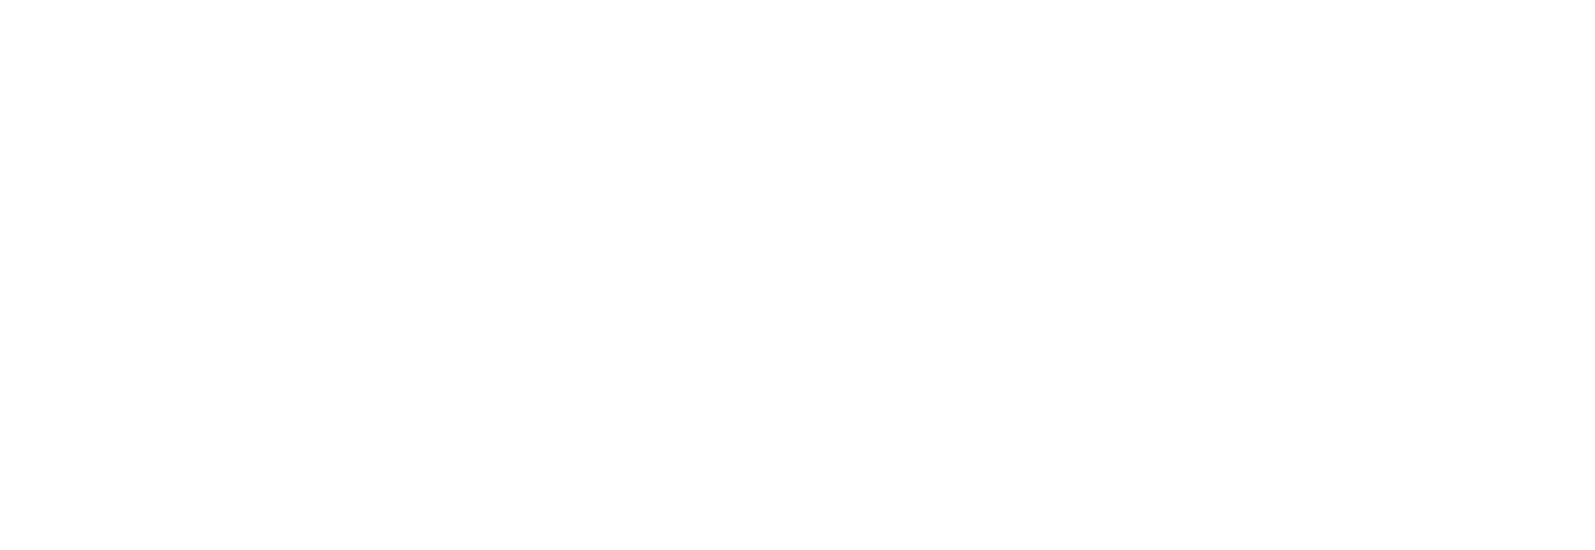

<IPython.core.display.Javascript object>


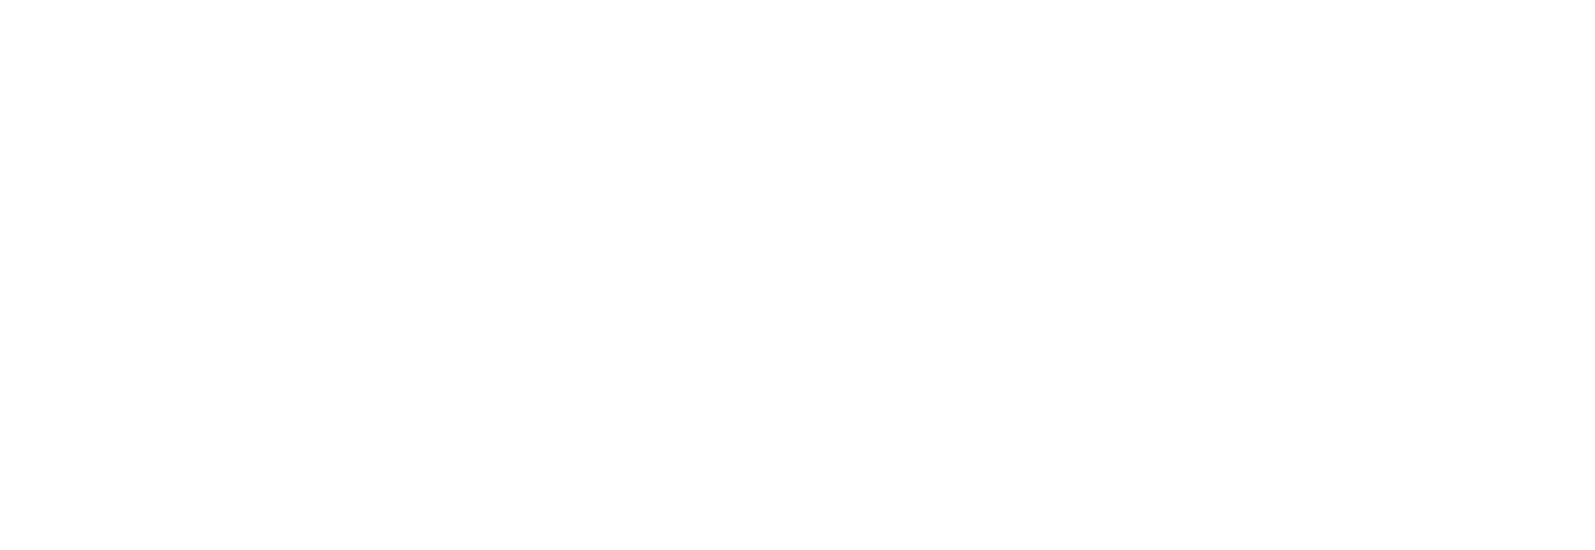

<IPython.core.display.Javascript object>


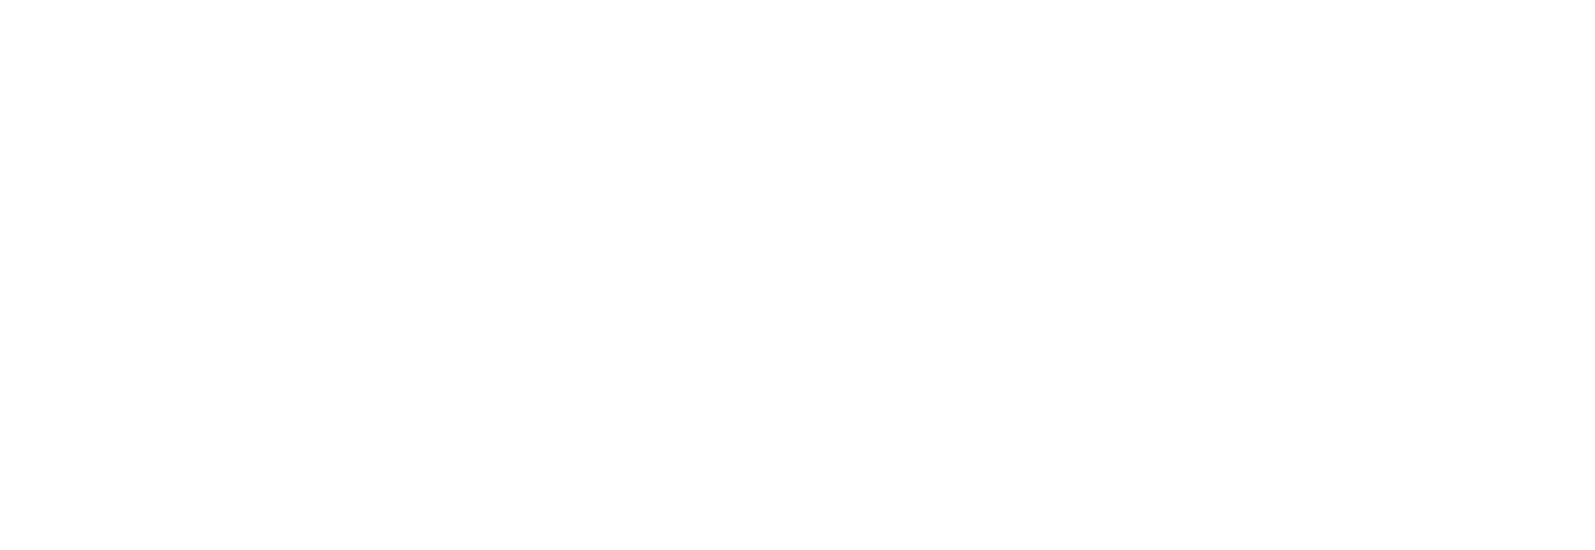

<IPython.core.display.Javascript object>


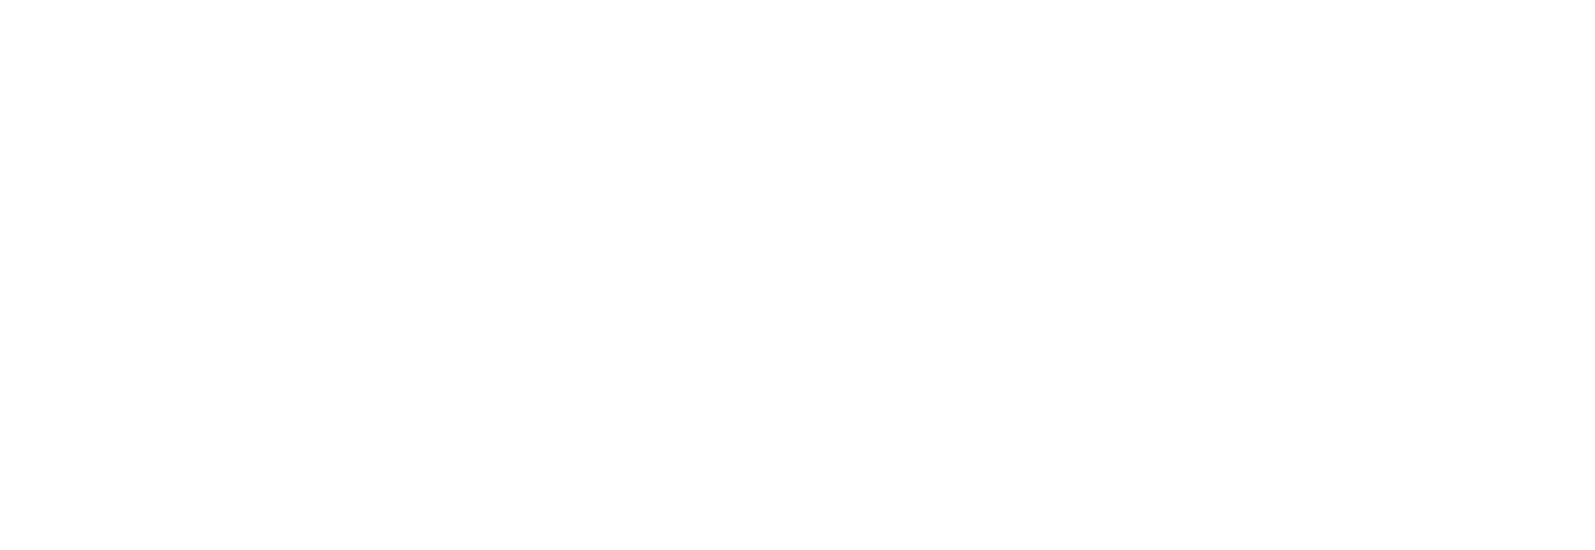

<IPython.core.display.Javascript object>


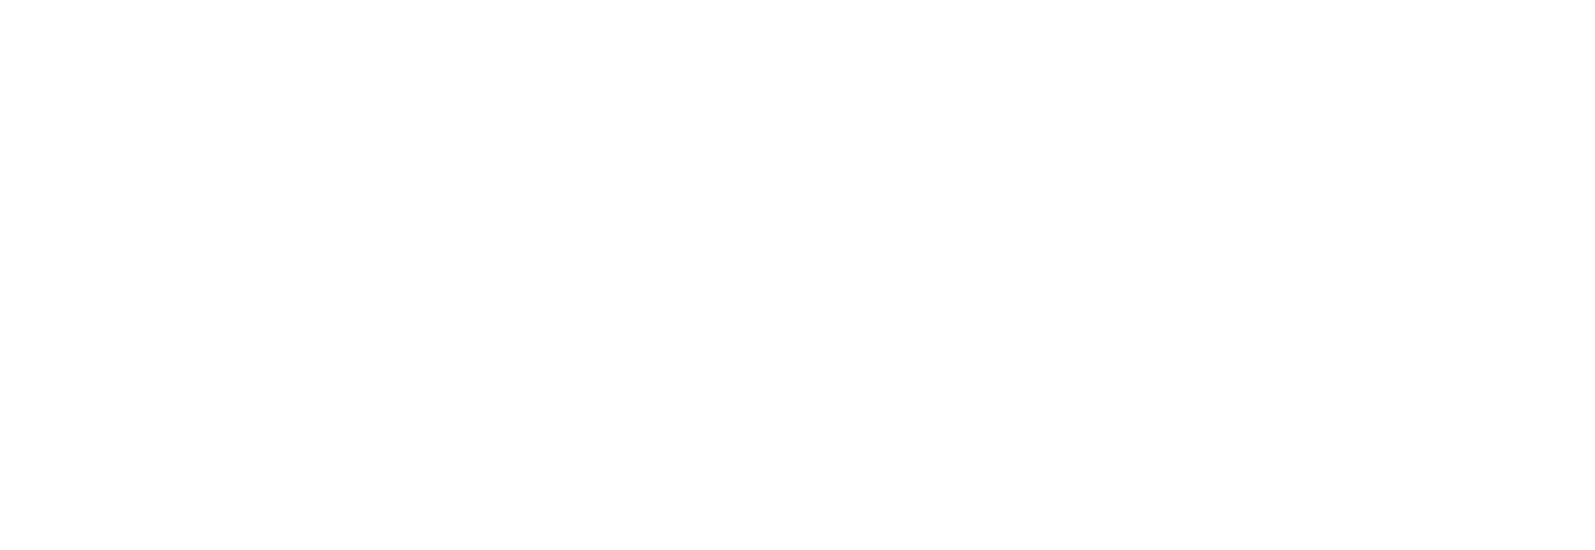

<IPython.core.display.Javascript object>


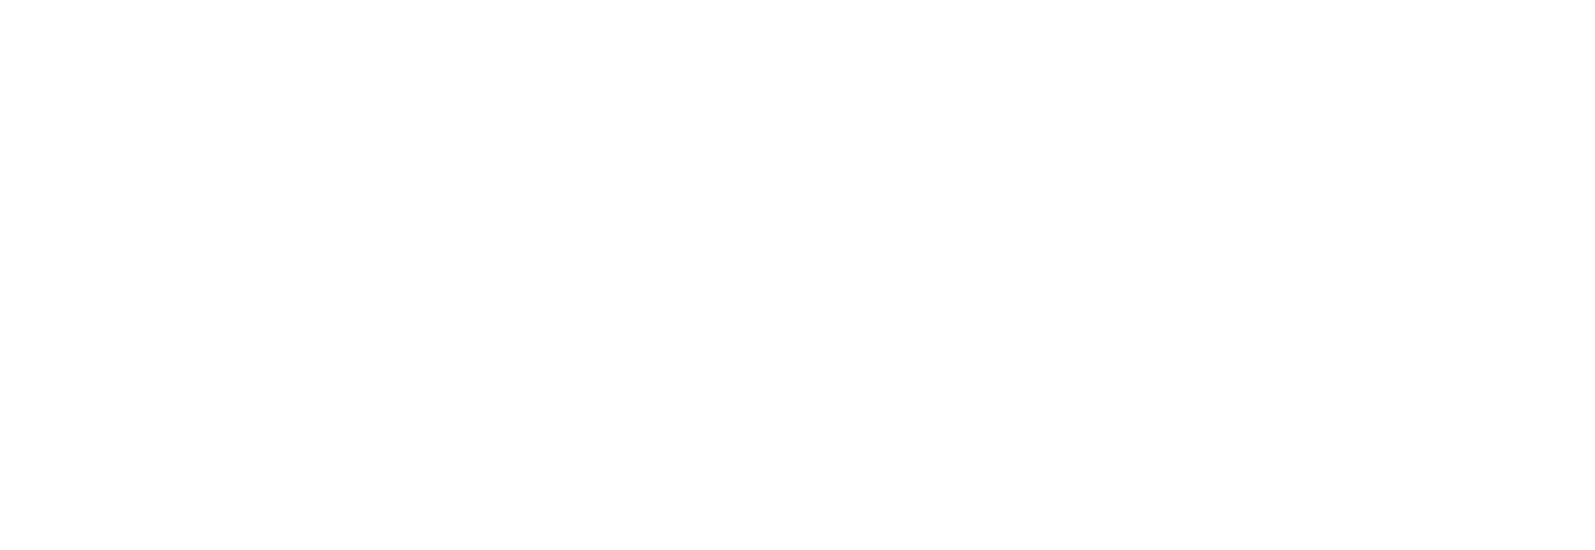

<IPython.core.display.Javascript object>


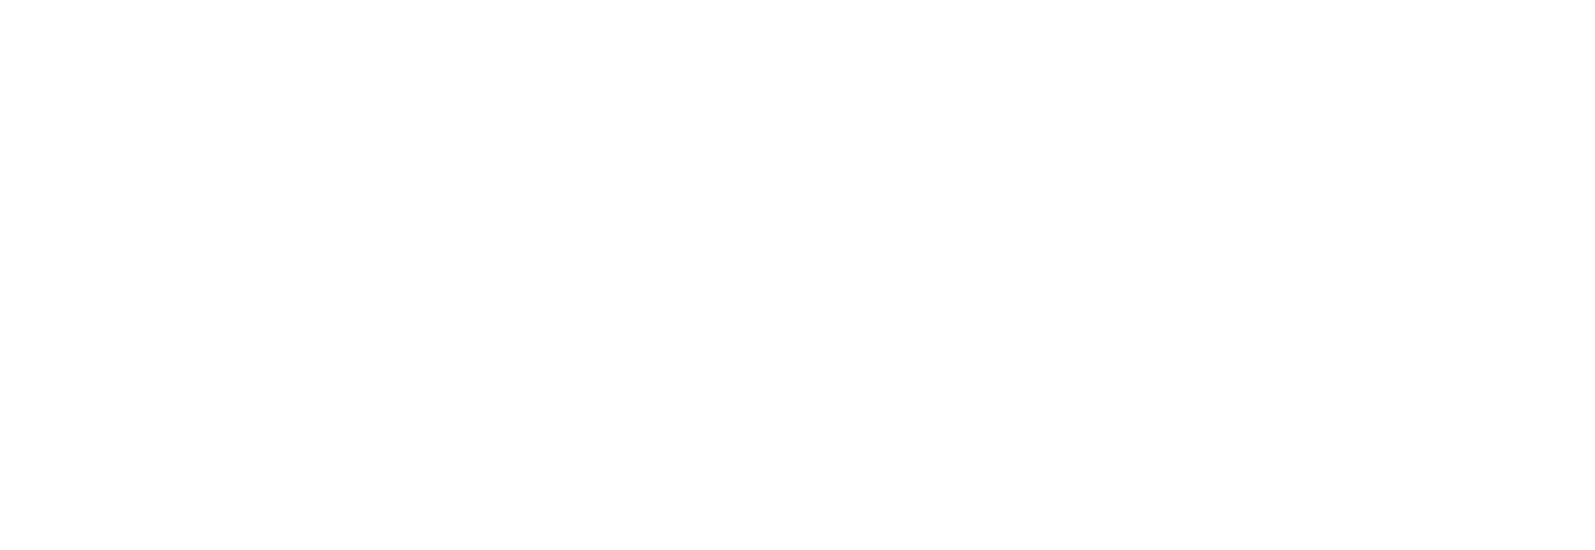

<IPython.core.display.Javascript object>


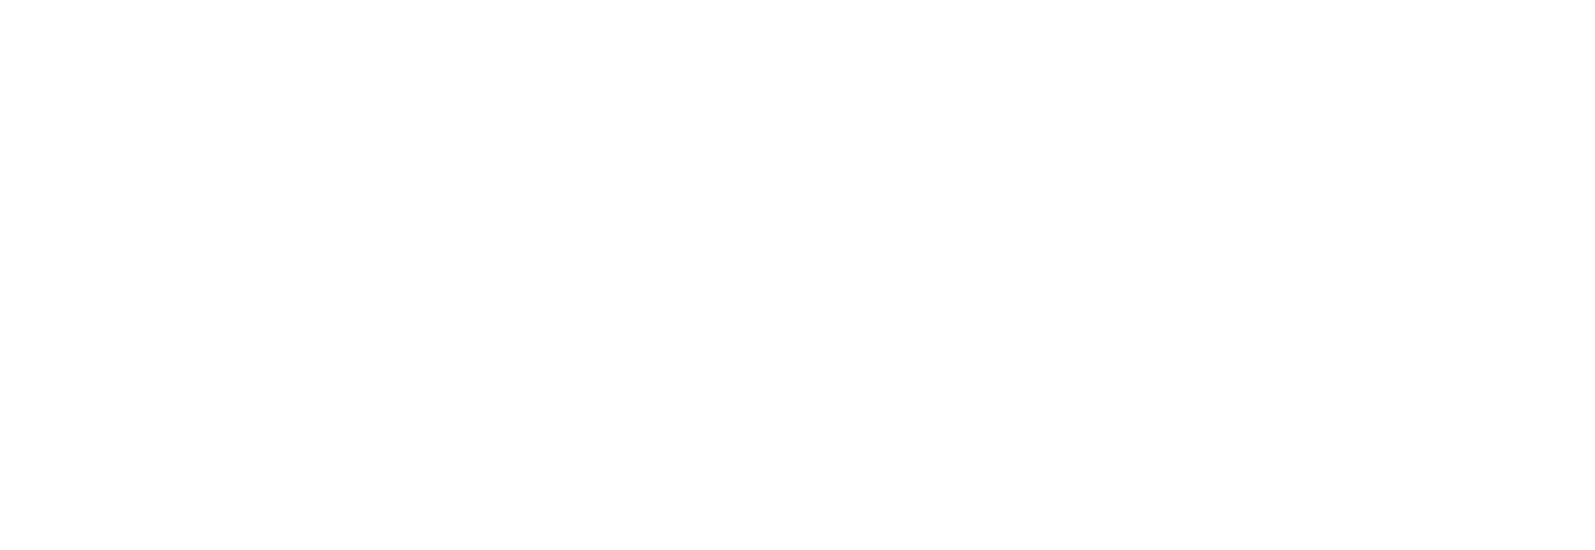

<IPython.core.display.Javascript object>


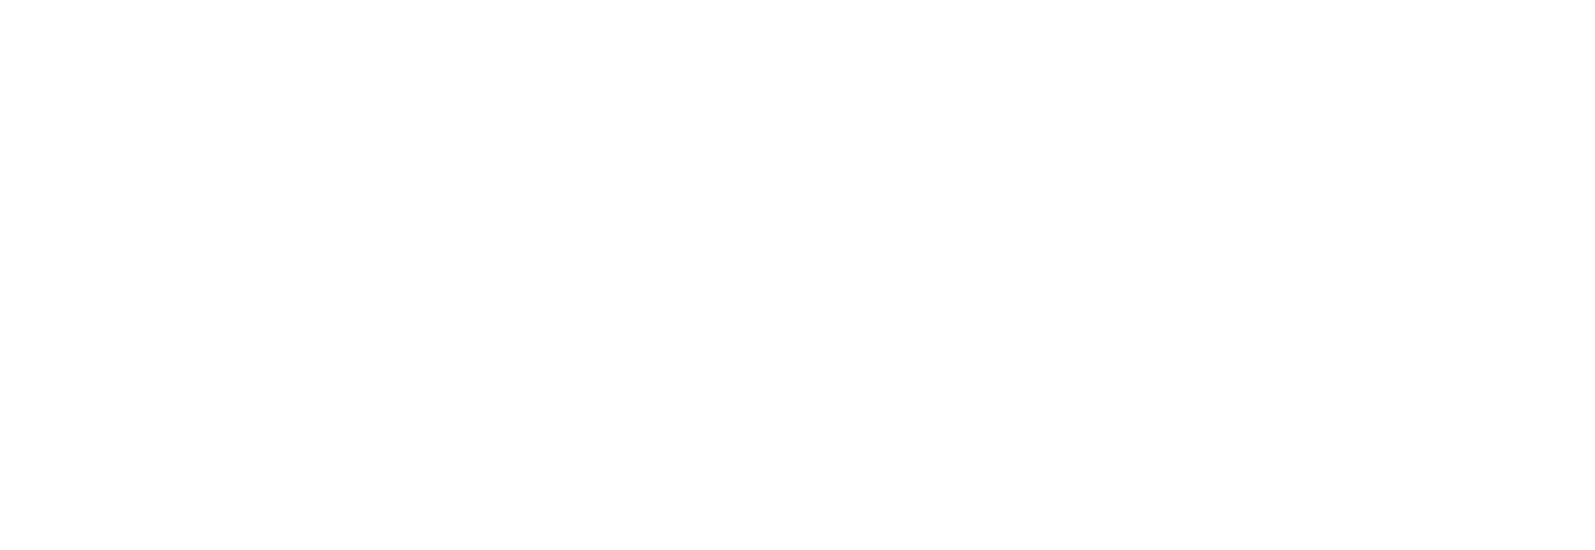

<IPython.core.display.Javascript object>


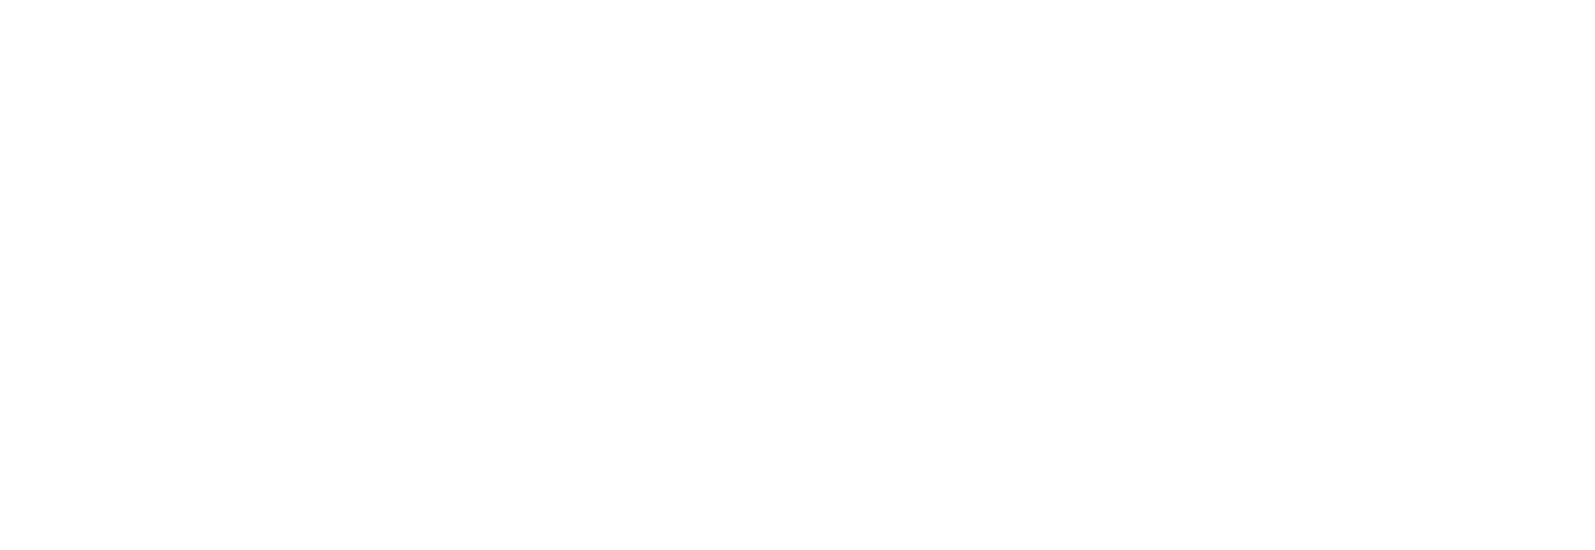

<IPython.core.display.Javascript object>


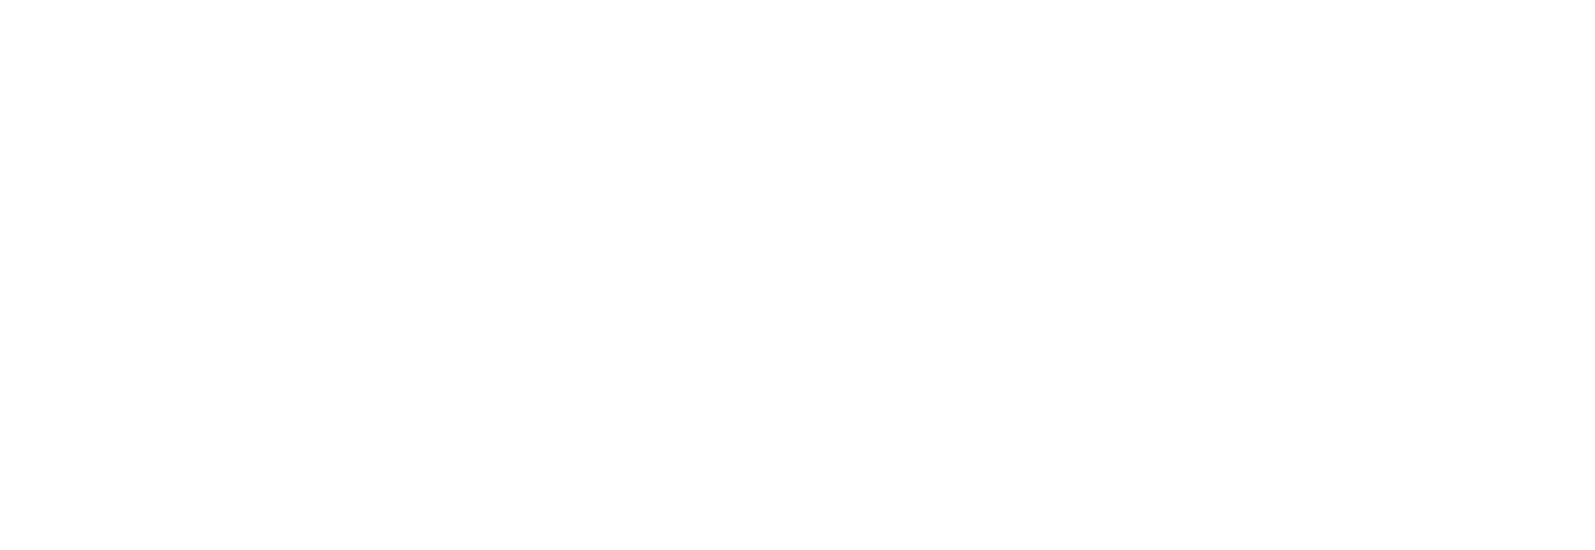

<IPython.core.display.Javascript object>


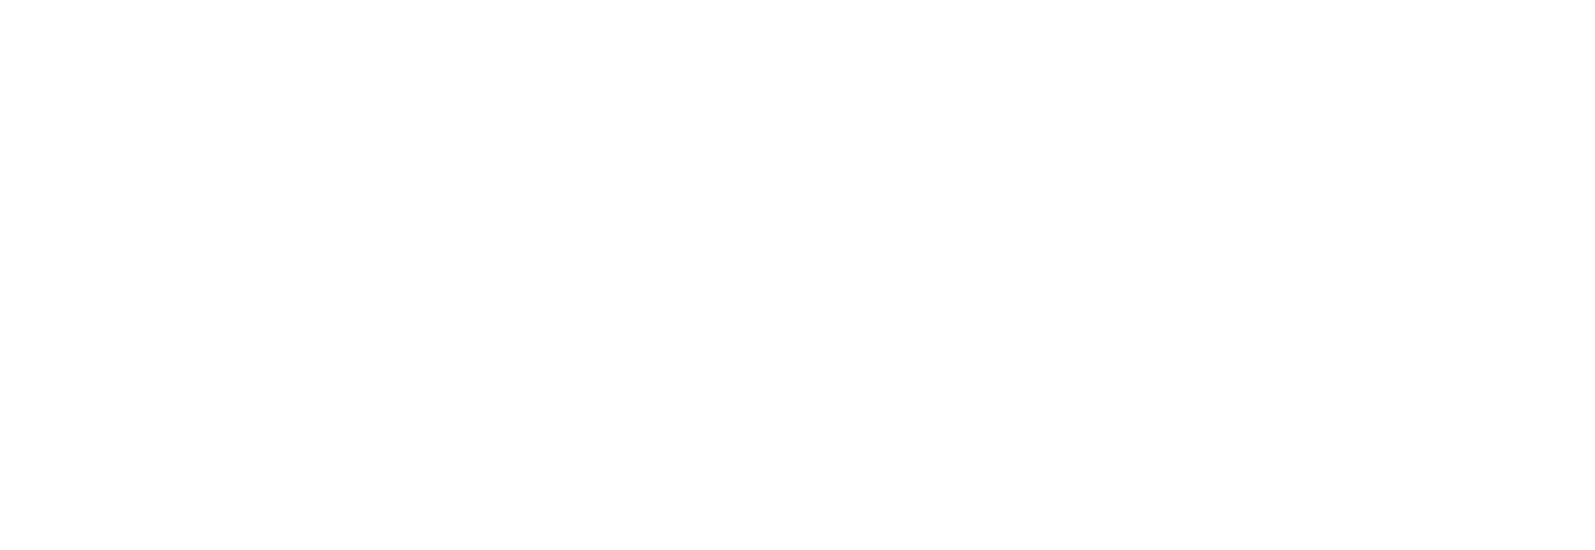

<IPython.core.display.Javascript object>


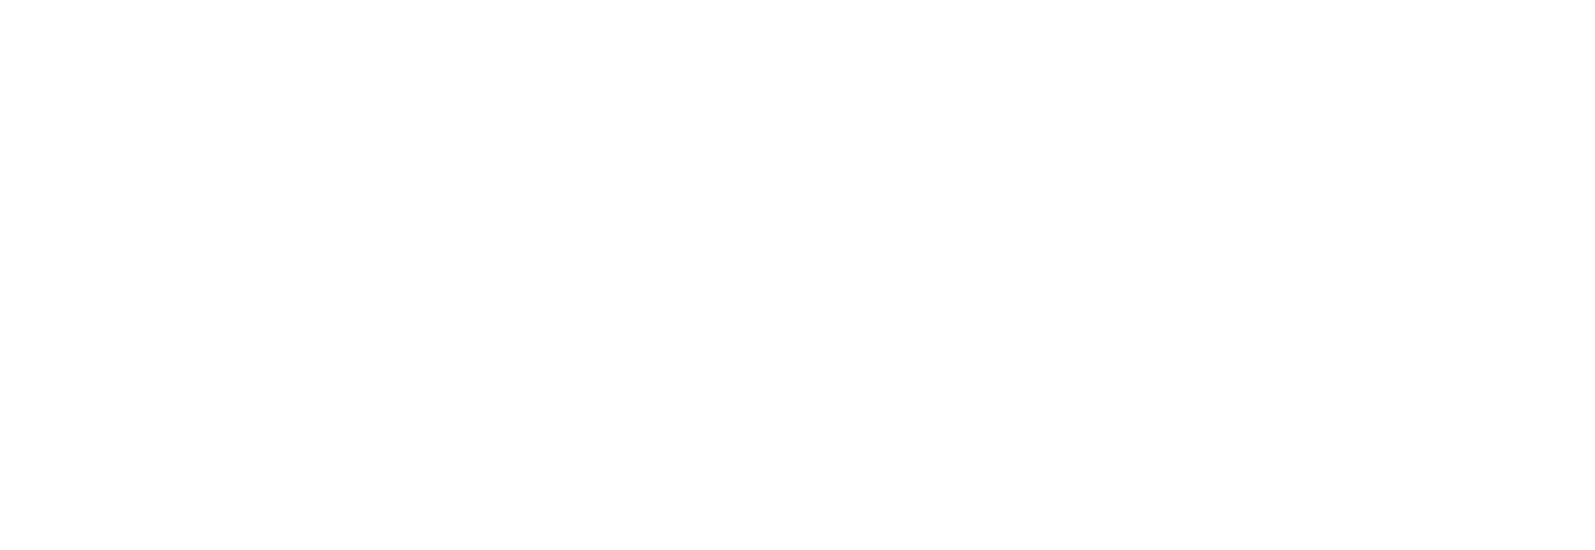

<IPython.core.display.Javascript object>


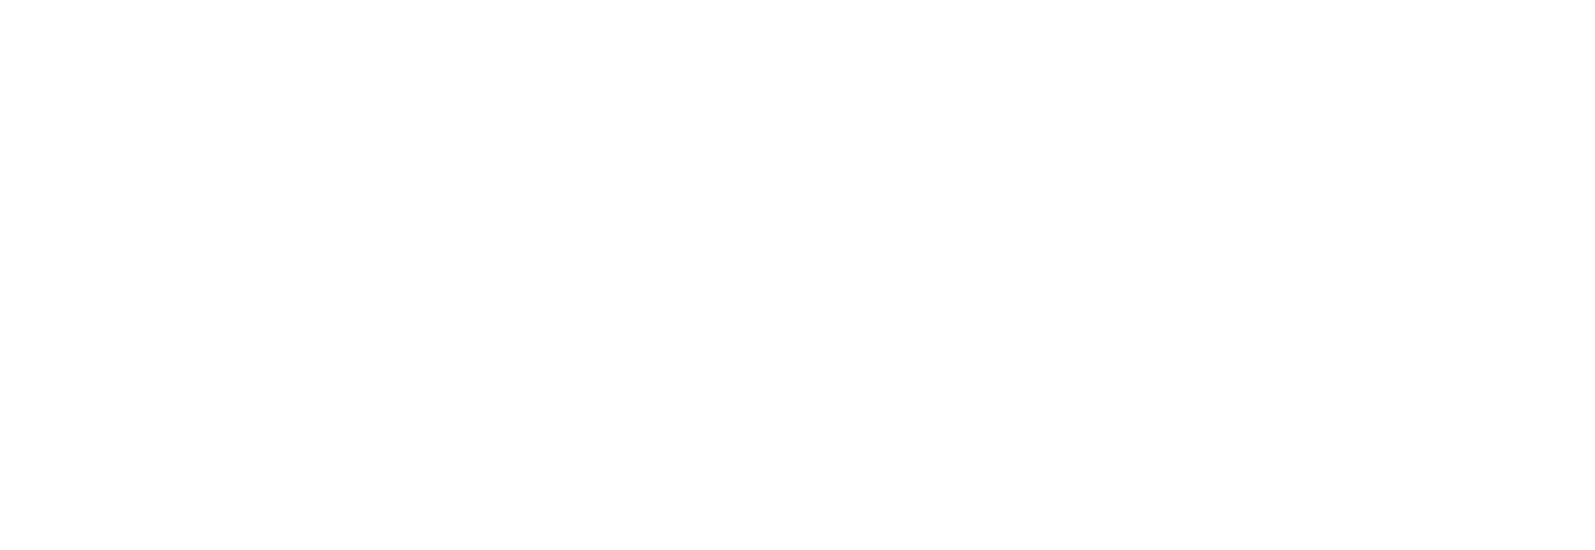

<IPython.core.display.Javascript object>


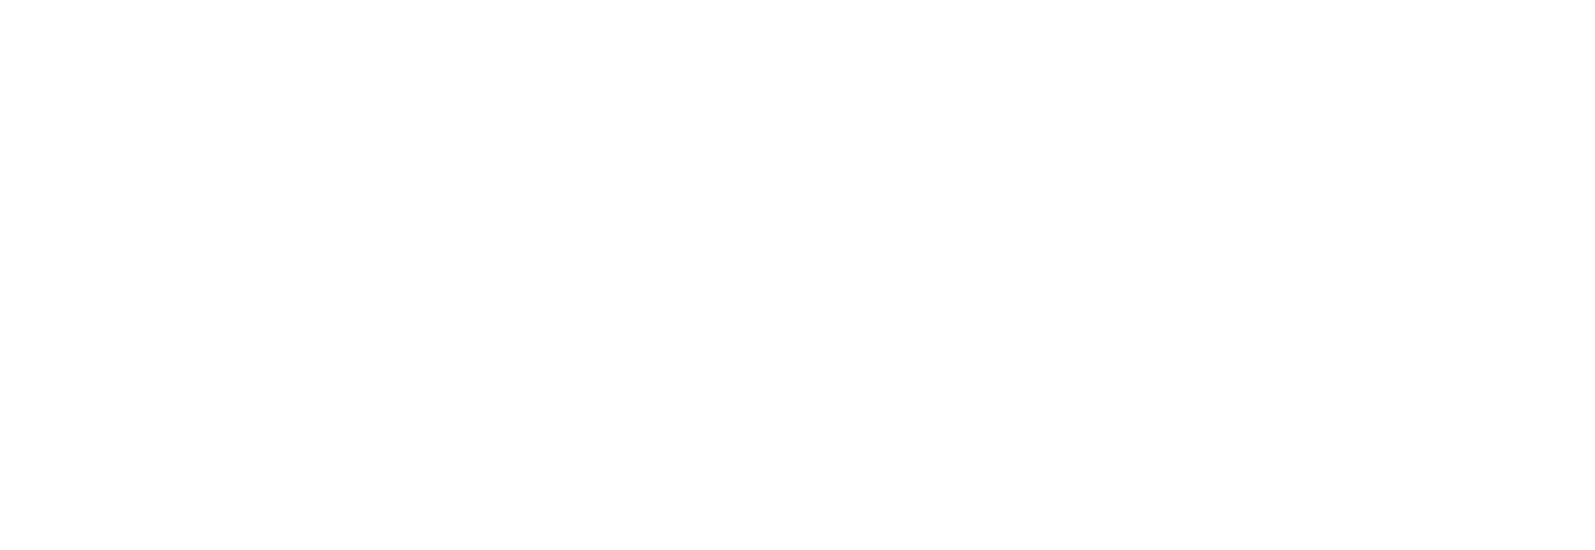

<IPython.core.display.Javascript object>


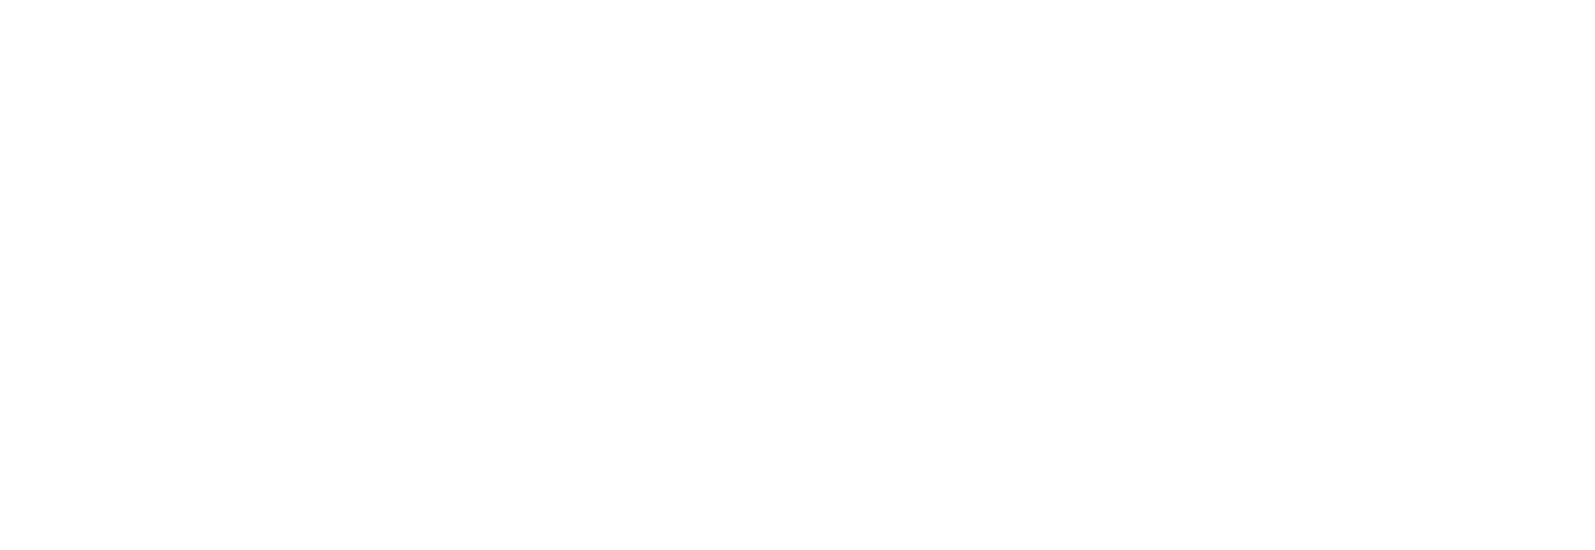

<IPython.core.display.Javascript object>


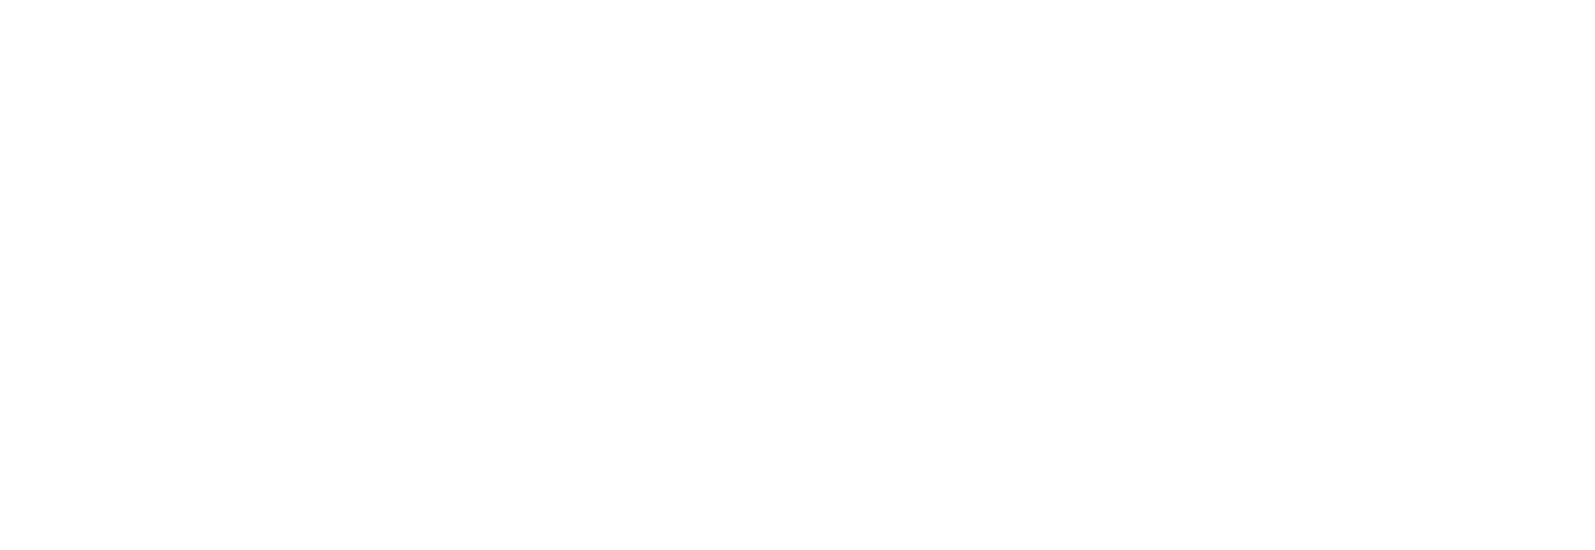

<IPython.core.display.Javascript object>


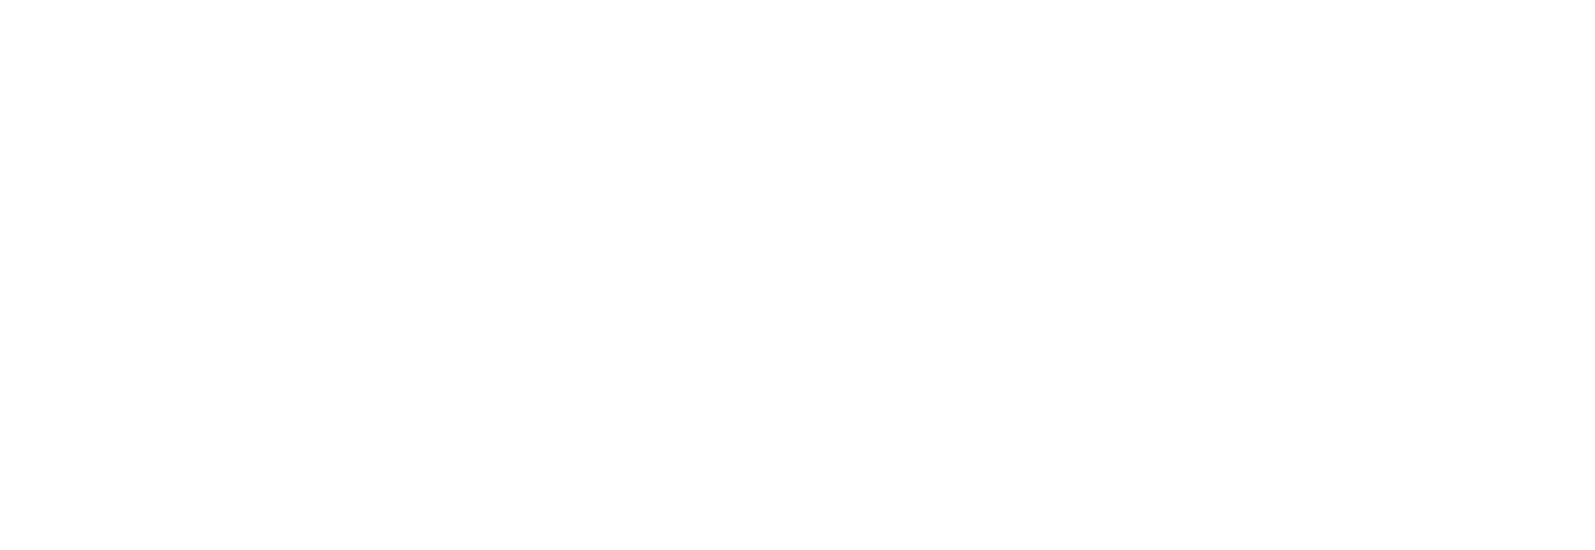

<IPython.core.display.Javascript object>


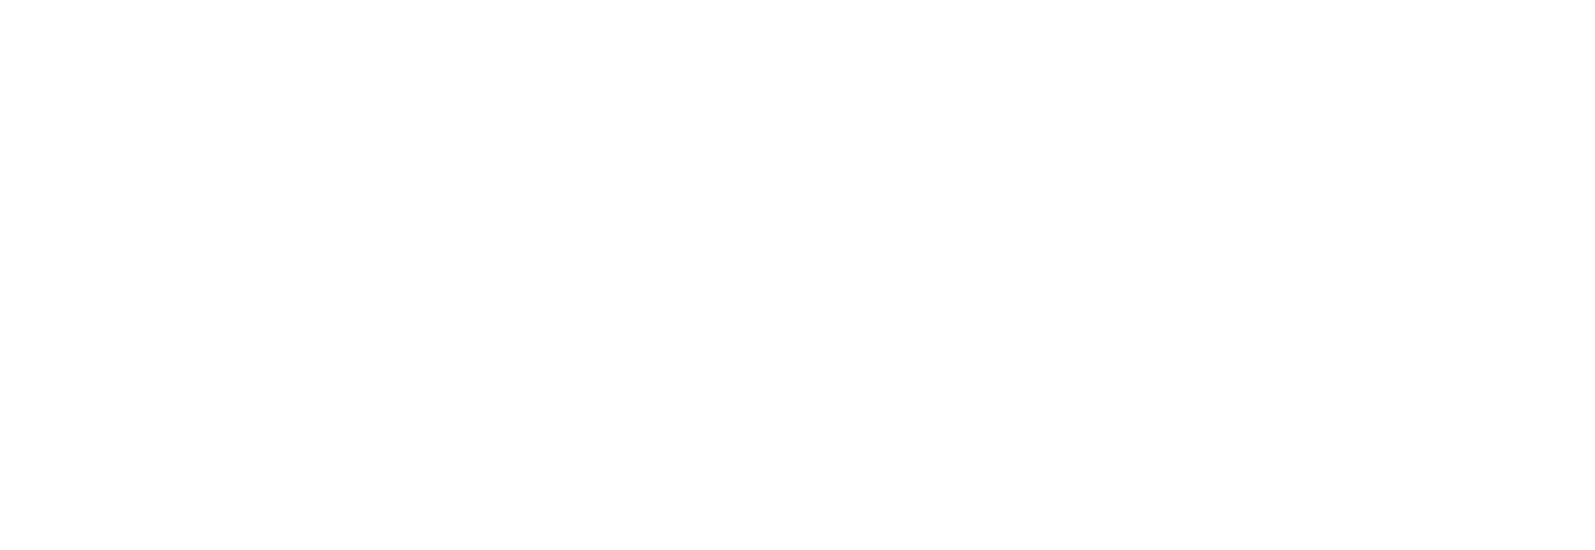

<IPython.core.display.Javascript object>


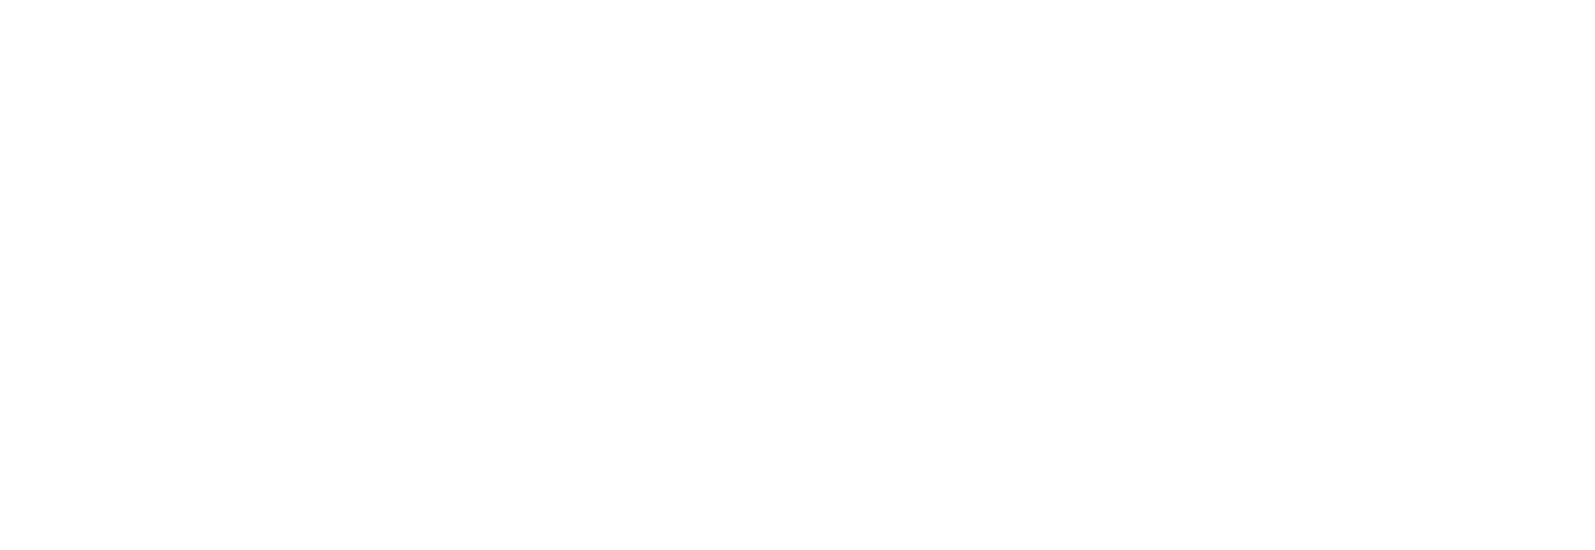

<IPython.core.display.Javascript object>


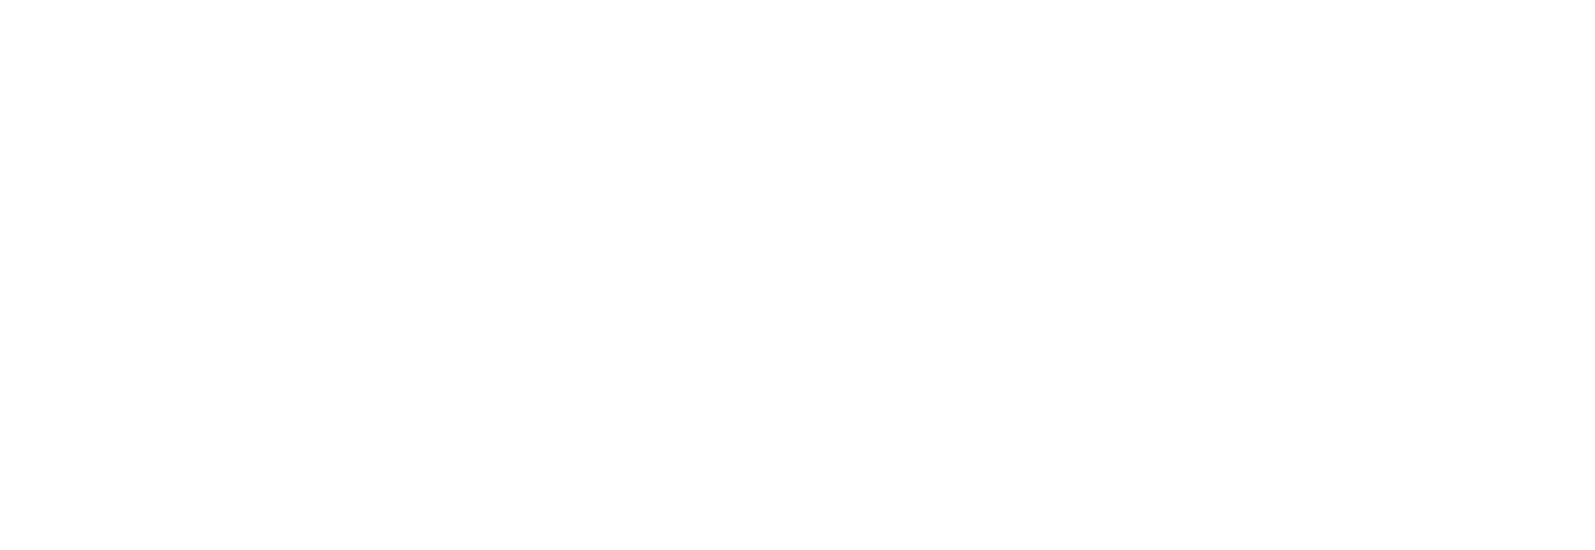

<IPython.core.display.Javascript object>


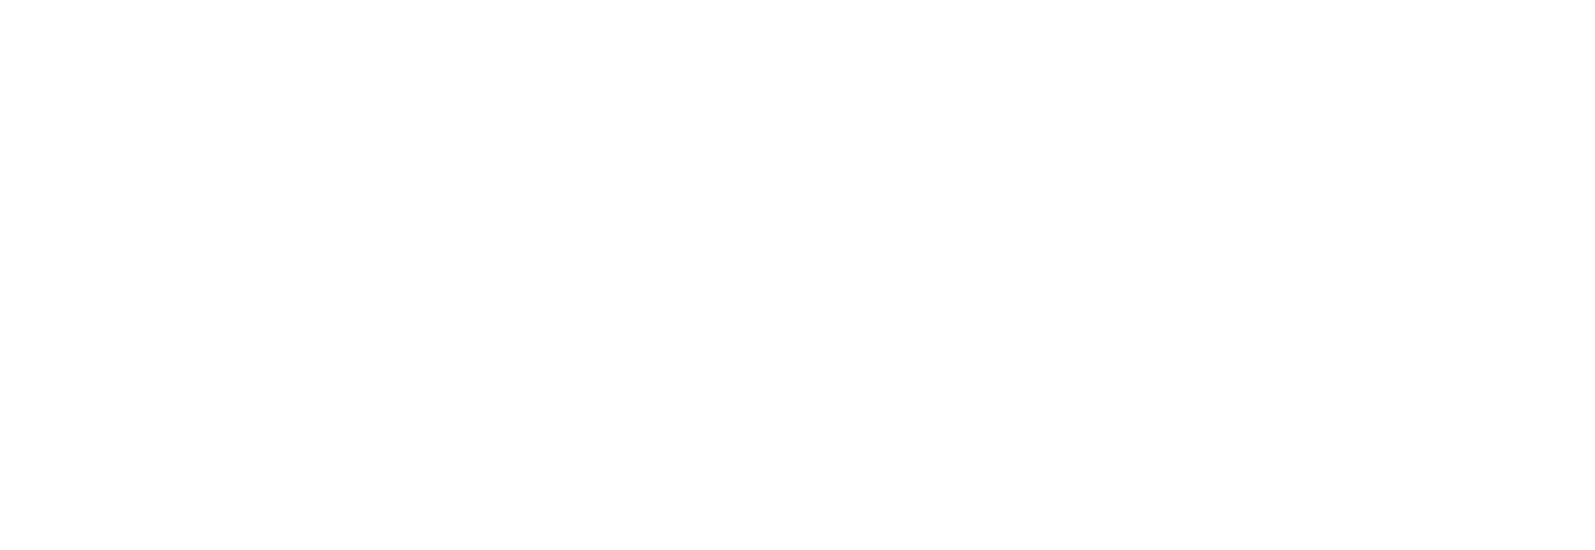

<IPython.core.display.Javascript object>


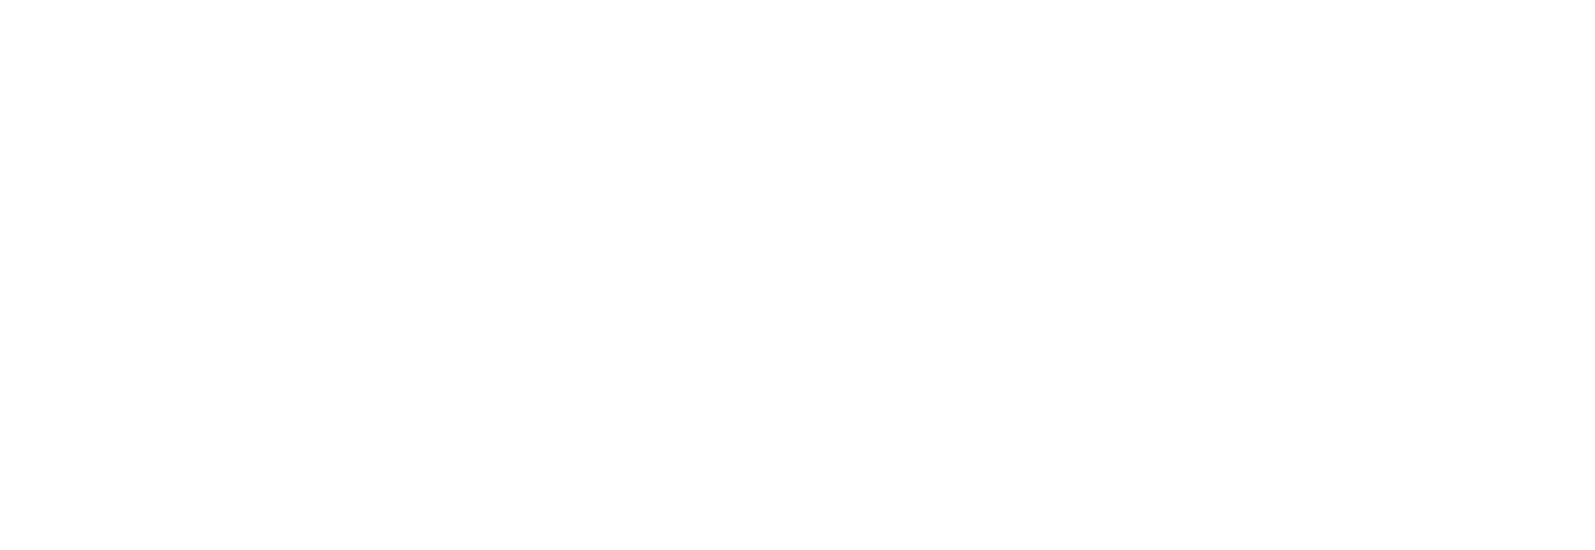

<IPython.core.display.Javascript object>


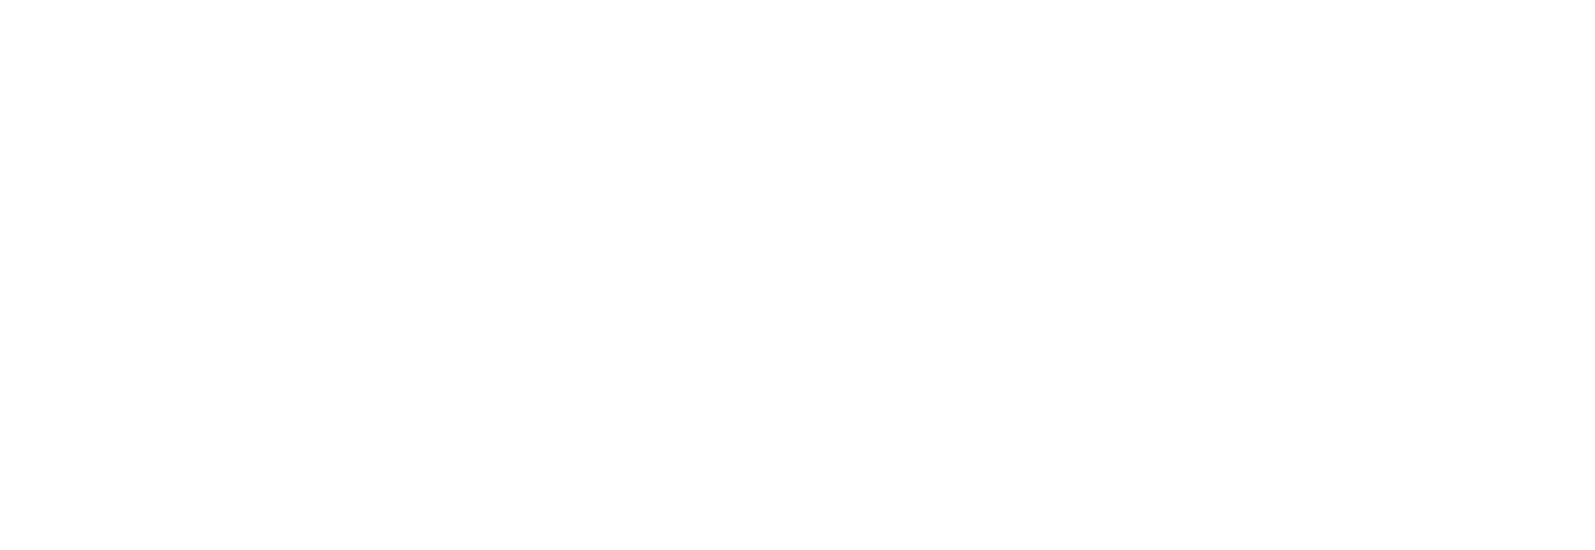

<IPython.core.display.Javascript object>


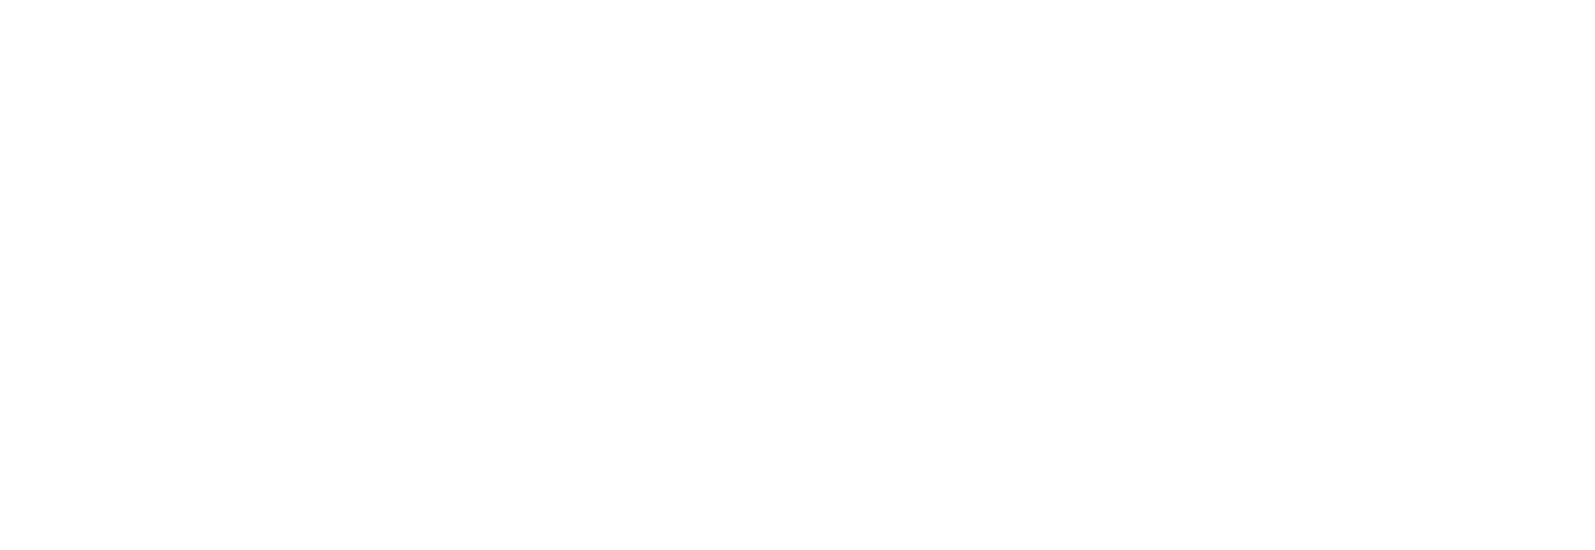

<IPython.core.display.Javascript object>


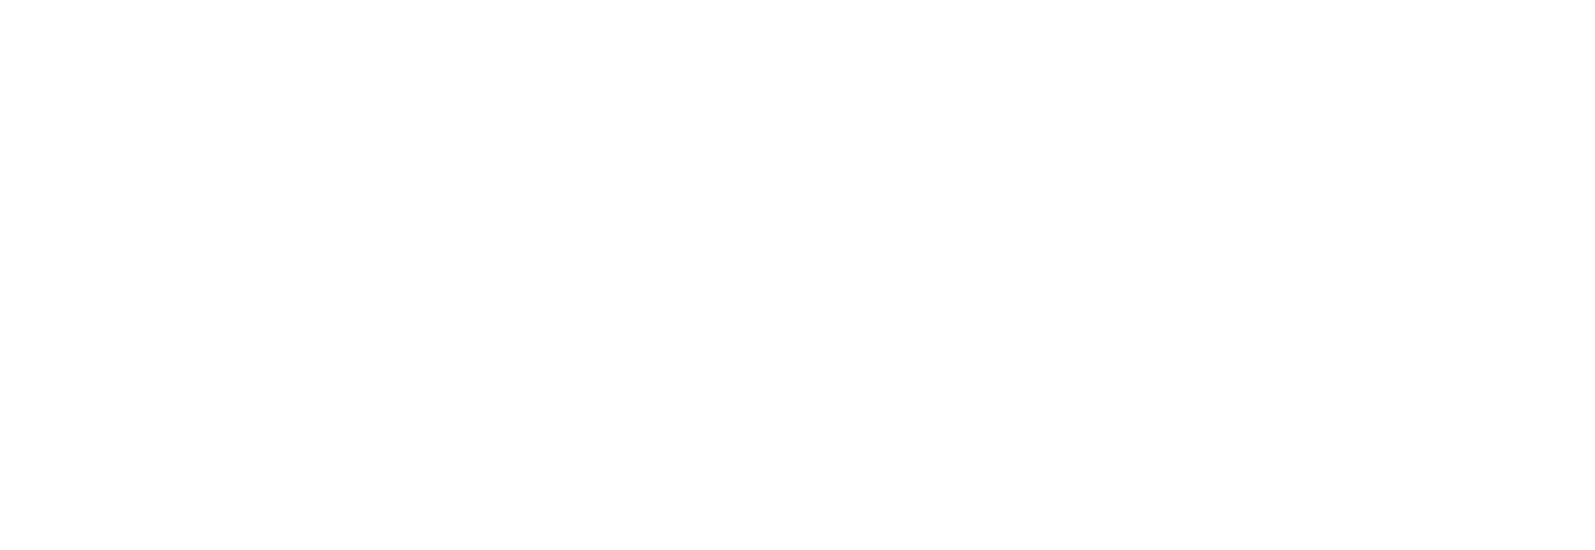

<IPython.core.display.Javascript object>


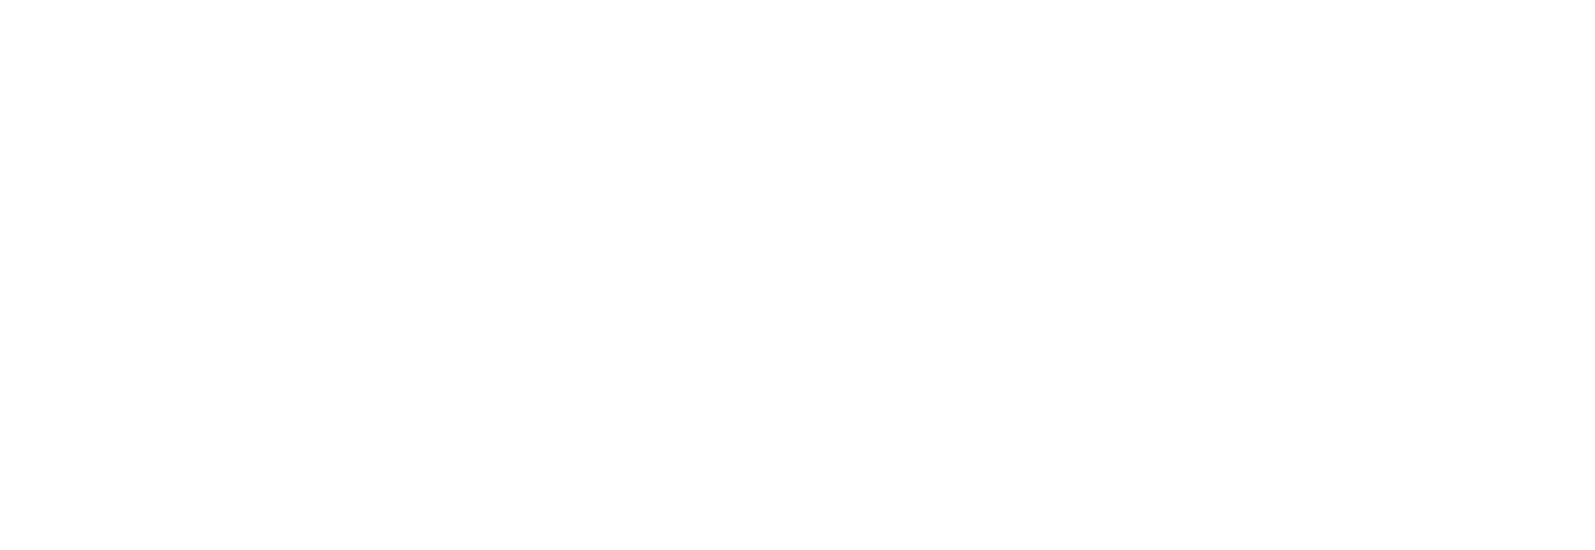

<IPython.core.display.Javascript object>


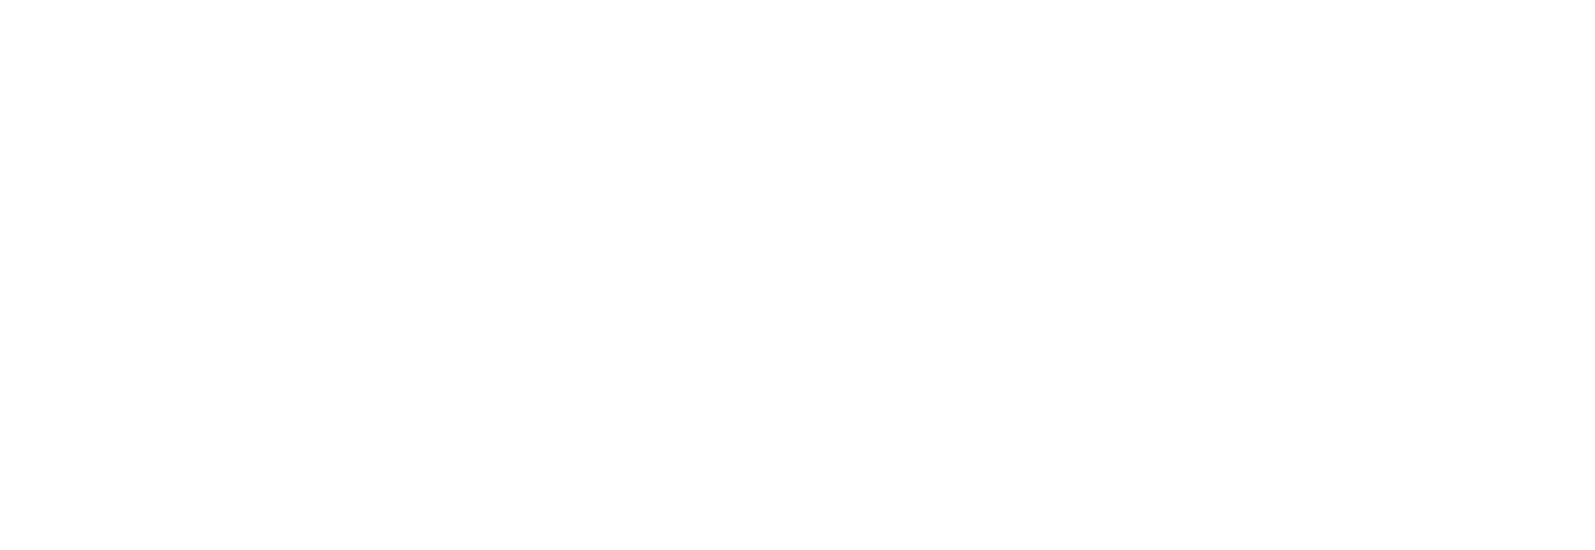

<IPython.core.display.Javascript object>


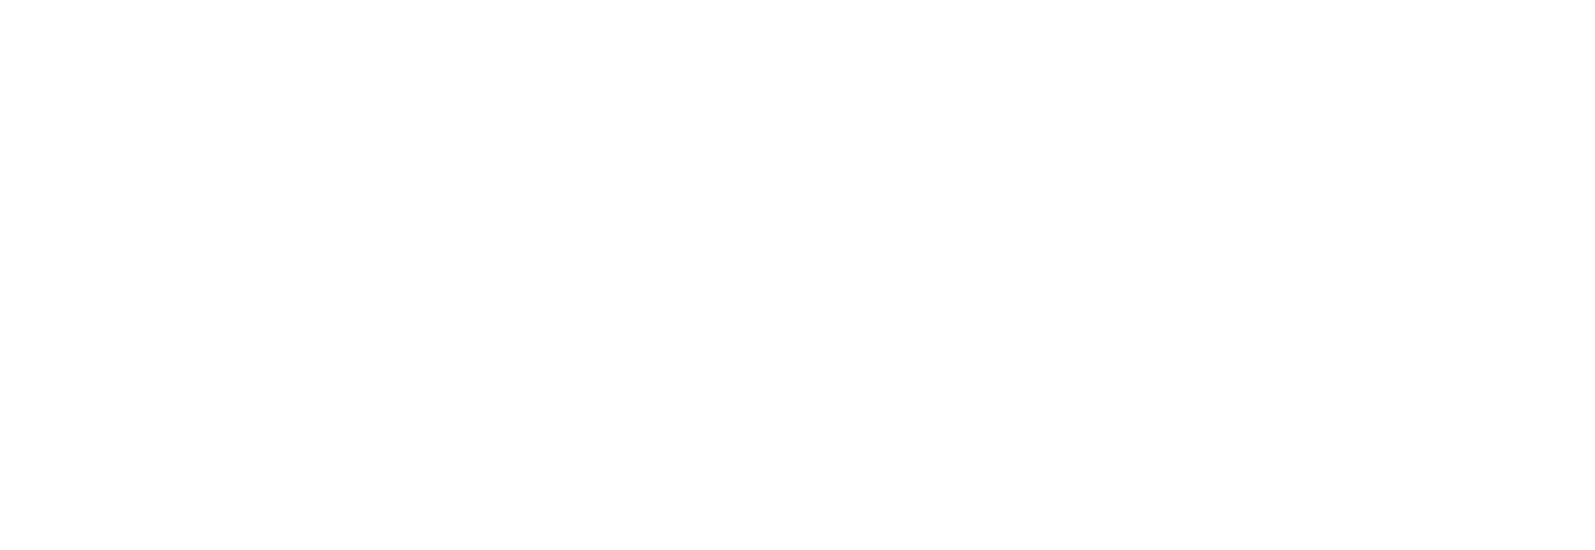

<IPython.core.display.Javascript object>


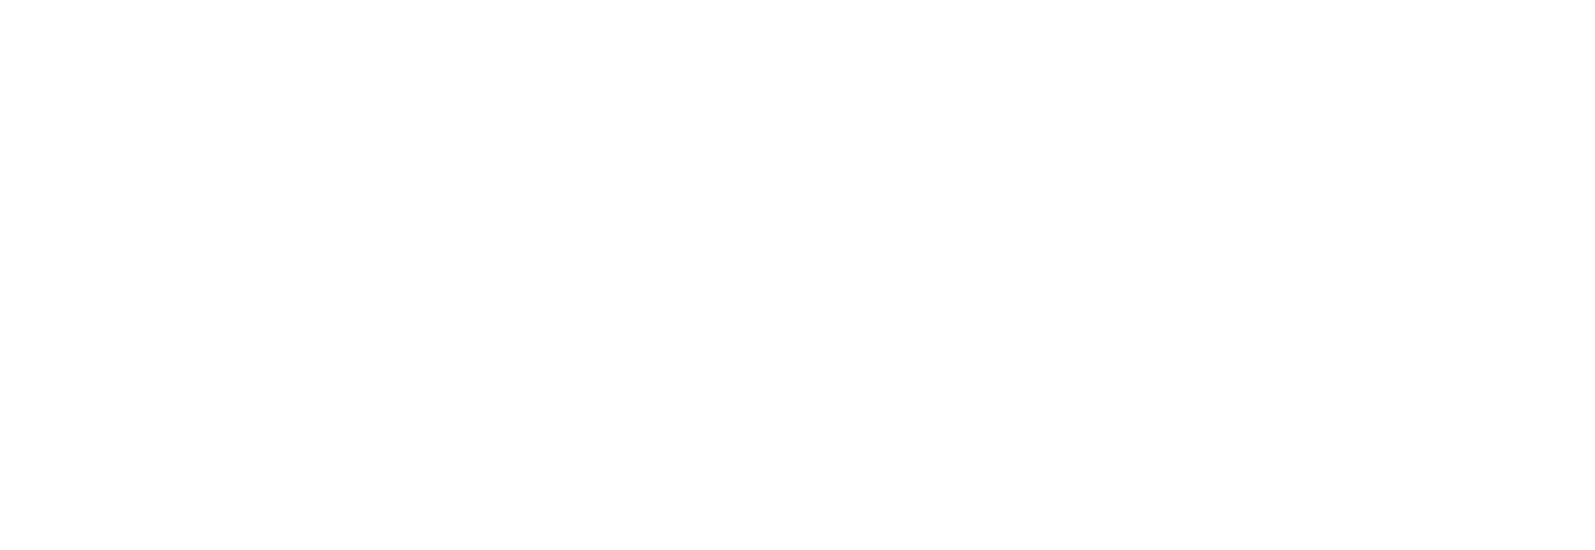

<IPython.core.display.Javascript object>


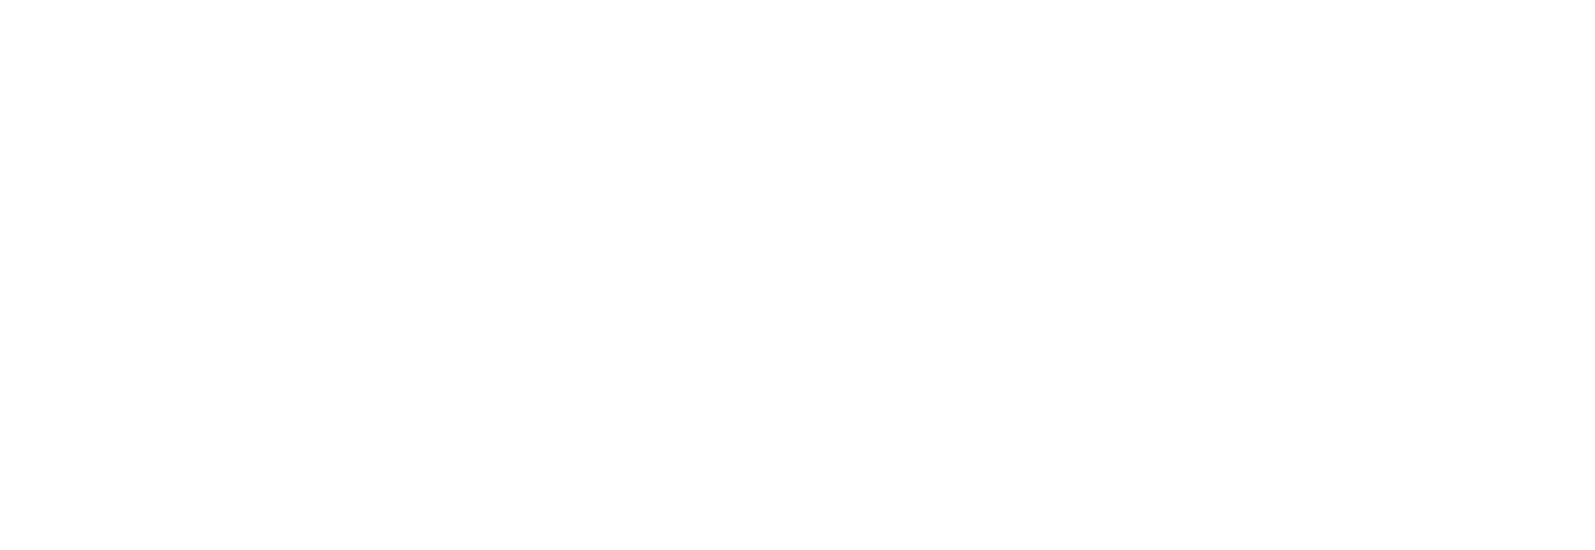

<IPython.core.display.Javascript object>


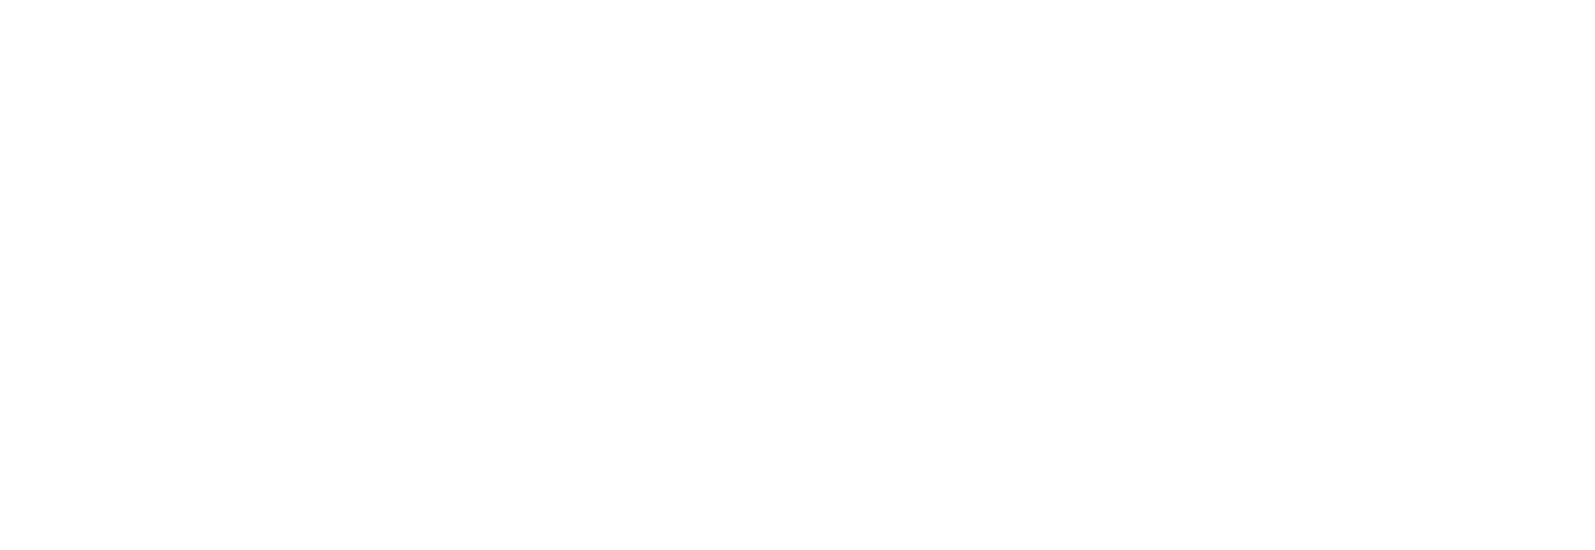

<IPython.core.display.Javascript object>


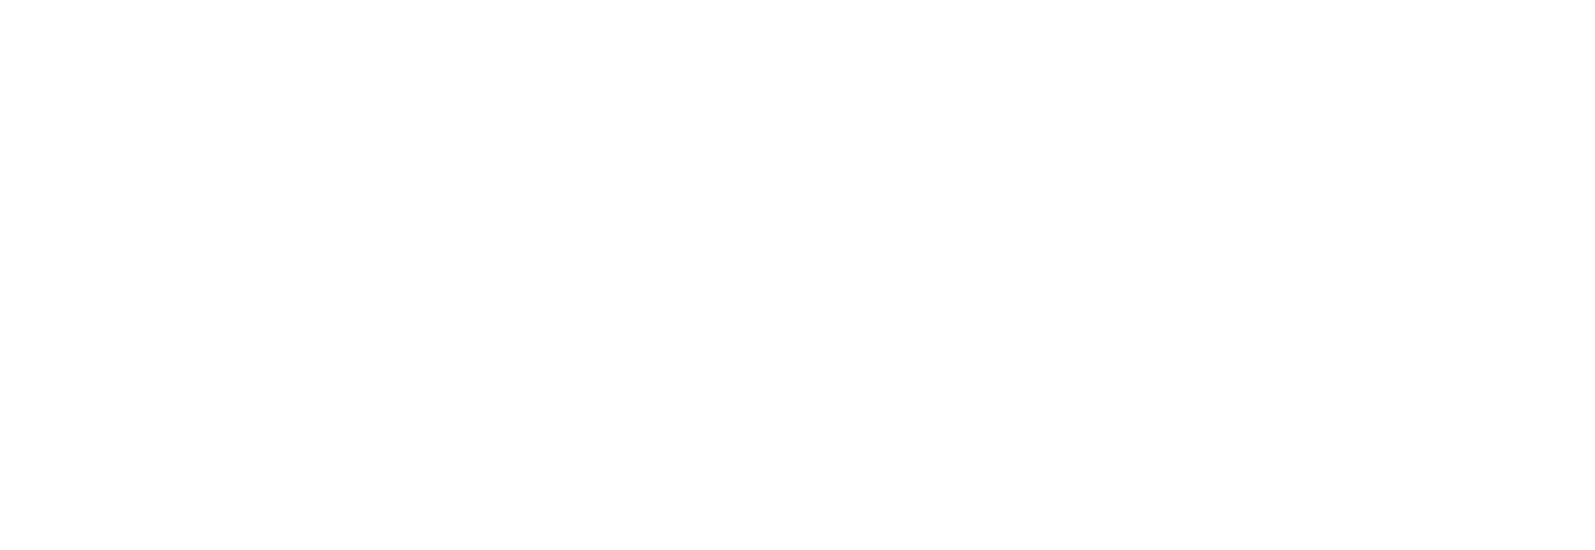

In [51]:
for ind in range(33):

    s=1
    fig = plt.figure(figsize=[14.5,5])
    temp = f'{getdihname(cri_dih[ind])}'

    ax2 = plt.subplot(131, polar=True)
    ax2.hist(dih_gly_down[:,cri_dih[ind]], bins=np.linspace(-np.pi, np.pi, 1000), bottom=2, 
                label='down', density=True, alpha=0.8, color='orange')
    ax2.hist(dih_gly_up[:,cri_dih[ind]], bins=np.linspace(-np.pi, np.pi, 1000), bottom=2, 
                label='up', density=True, alpha=0.8, color='steelblue')
    plt.title(temp+' Distribution in MD\n', fontsize=13)
    plt.legend(loc='best', fontsize=11)
#     plt.ylabel(fontsize=11)
#     plt.xlabel(fontsize=11)
    convert_polar_xticks_to_radians(ax2)


    ax = fig.add_subplot(132, polar=True)
    ss = 1
    ax.scatter(diheset_gly_d2u_cri[0][:,ind][::ss], np.arange(len(diheset_gly_d2u_cri[0][:,ind][::ss])),
                label='rep1', s=1, c=d2u_color[0], alpha=1.0)
    ax.scatter(diheset_gly_d2u_cri[1][:,ind][::ss], np.arange(len(diheset_gly_d2u_cri[1][:,ind][::ss])), 
                label='rep2', s=1, c=d2u_color[1], alpha=0.9)
    ax.scatter(diheset_gly_d2u_cri[2][:,ind][::ss], np.arange(len(diheset_gly_d2u_cri[2][:,ind][::ss])),
                label='rep3', s=1, c=d2u_color[2],  alpha=0.8)
    ax.scatter(diheset_gly_d2u_cri[3][:,ind][::ss], np.arange(len(diheset_gly_d2u_cri[3][:,ind][::ss])),
                label='rep4', s=1, c=d2u_color[3],  alpha=0.7)
    ax.scatter(diheset_gly_d2u_cri[4][:,ind][::ss], np.arange(len(diheset_gly_d2u_cri[4][:,ind][::ss])), 
                label='rep5', s=1, c=d2u_color[4],  alpha=0.6)
    # plt.ylabel('frame')
    plt.ylim(0, 4000)
    plt.yticks([1000, 2000, 3000, 4000], ['1 ns','2 ns','3 ns','4 ns'], fontsize=11)
    plt.title(temp+' in Opening\n', fontsize=13)
    plt.legend(loc='best', fontsize=11, markerscale=3.)
    convert_polar_xticks_to_radians(ax)



    ax3 = fig.add_subplot(133, polar=True)
    ss = 1
    ax3.scatter(diheset_gly_u2d_cri[0][:,ind][::ss], np.arange(len(diheset_gly_u2d_cri[0][:,ind][::ss])),
                label='rep1', s=1, c=u2d_color[0], alpha=1.0)
    ax3.scatter(diheset_gly_u2d_cri[1][:,ind][::ss], np.arange(len(diheset_gly_u2d_cri[1][:,ind][::ss])), 
                label='rep2', s=1, c=u2d_color[1], alpha=0.9)
    ax3.scatter(diheset_gly_u2d_cri[2][:,ind][::ss], np.arange(len(diheset_gly_u2d_cri[2][:,ind][::ss])),
                label='rep3', s=1, c=u2d_color[2], alpha=0.8)
    ax3.scatter(diheset_gly_u2d_cri[3][:,ind][::ss], np.arange(len(diheset_gly_u2d_cri[3][:,ind][::ss])),
                label='rep4', s=1, c=u2d_color[3], alpha=0.7)
    ax3.scatter(diheset_gly_u2d_cri[4][:,ind][::ss], np.arange(len(diheset_gly_u2d_cri[4][:,ind][::ss])), 
                label='rep5', s=1, c=u2d_color[4], alpha=0.6)
    # plt.ylabel('frame')
    plt.title(temp+' in Closing\n', fontsize=13)
#     plt.ylabel('ns', fontsize=11)
    plt.ylim(0, 4000)
    plt.yticks([1000, 2000, 3000, 4000], ['1 ns','2 ns','3 ns','4 ns'], fontsize=11)
    plt.legend(loc='best', fontsize=11, markerscale=3.)
    convert_polar_xticks_to_radians(ax3)


    plt.tight_layout()
#     plt.show()
    plt.savefig(f'ReportPlots/cri_dih_dist/{temp.split(" ")[0]}_{temp.split(" ")[1]}', dpi=300)
    plt.close()